In [62]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

1.13.0+cu116


In [2]:
import torch_geometric
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax



##Model Definition

In [3]:
def accuracy(pred_y,y):
  return ((pred_y == y).sum() / len(y)).item()

In [4]:
class GraphModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args,embedding=False):
        super(GraphModel, self).__init__()
        conv_model=GATConv
        if args["model_type"]=='GAT':
          conv_model=GAT
        elif args["model_type"]=='GATv2':
          conv_model=GATv2
        elif args["model_type"]=='GATConvv2':
          conv_model=GATConvv2
        elif args["model_type"]=='GCN':
          conv_model=GCN
        elif args["model_type"]=='GCN_sum':
          conv_model=GCN_sum
        self.convs = nn.ModuleList()
        print("heads")
        print(args["heads"])
        self.convs.append(conv_model(input_dim, hidden_dim, heads=args["heads"],dropout=args["dropout"]))
        for l in range(args["num_layers"]-1):
            self.convs.append(conv_model(args["heads"] * hidden_dim, hidden_dim,heads=args["heads"]))
        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(args["heads"] * hidden_dim, hidden_dim), nn.Dropout(args["dropout"]), 
            nn.Linear(hidden_dim, output_dim))
        self.dropout = args["dropout"]
        self.num_layers = args["num_layers"]
        self.embedding=embedding
        self.attention=None
    def forward(self, data):
        if(self.embedding==False):
          x, edge_index, batch = data.x, data.edge_index, data.batch   
        else:
          x, edge_index=data.x, data.edge_index
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            #self.attention=self.convs[i].getAttention()
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout)
        x = self.post_mp(x)
        return F.log_softmax(x, dim=1)
    def generate_emb(self,data):
        x, edge_index=data.x, data.edge_index
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
        return x
    def loss(self, pred, label):
        return F.cross_entropy(pred, label)
    def minmaxAttention(self):
        print(self.attention)
    

##GCN definition


###fixed normalized aggergation

In [5]:
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCN(MessagePassing):
    def __init__(self, in_channels, out_channels,heads=1,dropout=0):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] + deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

###fixed aggregation: sum

In [25]:
'''
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch_geometric.utils as U
class GCN_sum(MessagePassing):
    def __init__(self, in_channels, out_channels,heads=1,dropout=0):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.w1=nn.Linear(in_channels,out_channels)
        self.w2=nn.Linear(in_channels,out_channels)
        self.reset_parameters()

    def reset_parameters(self):
        self.w1.reset_parameters()
        self.w2.reset_parameters()
        #self.bias.data.zero_()

    def forward(self, x, edge_index):
        edge_index = U.to_dense_adj(edge_index).squeeze(0)
        propagated_msgs=torch.mm(edge_index, x)
        potential_msgs=self.w2(propagated_msgs)
        root_update=self.w1(x)
        output = potential_msgs + root_update #+ self.bias
        return output
    def message(self, x_j):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        out = x_j
        return out
'''

In [6]:
'''
import torch
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCN_sum(MessagePassing):
    def __init__(self, in_channels, out_channels,heads=1,dropout=0):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.linr = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.linr.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        prop = self.propagate(edge_index, x=(x, x))
        out = self.lin(x) + self.linr(prop)
        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        out = x_j
        return out
'''

In [57]:
import torch_geometric.utils as U
class GCN_sum(nn.Module):
    
    def __init__(self, input_dim, output_dim, heads=1,dropout=0):
      super().__init__()
      #self.input_dim = input_dim
      #self.output_dim = output_dim
      #self.W2 = Parameter(torch.rand((input_dim, output_dim), dtype=torch.float32))
      #self.W1 = Parameter(torch.rand((input_dim, output_dim), dtype=torch.float32))
      #self.bias = Parameter(torch.zeros(output_dim, dtype=torch.float32))
      self.w1=nn.Linear(input_dim,output_dim)
      self.w2=nn.Linear(input_dim,output_dim)


    def forward(self, node_feats, adj_matrix):
      #potential_msgs = torch.mm(node_feats, self.W2)
      #propagated_msgs = torch.mm(adj_matrix, potential_msgs)
      #root_update = torch.mm(node_feats, self.W1)
      #adj_matrix = U.to_dense_adj(adj_matrix).squeeze(0)
      num_nodes=node_feats.size()[0]
       # batch = torch.zeros(size=num_nodes,dtype=torch.long)
      adj = U.to_dense_adj(adj_matrix,max_num_nodes=num_nodes).squeeze(0)
      propagated_msgs=torch.mm(adj, node_feats)
      potential_msgs=self.w2(propagated_msgs)
      root_update=self.w1(node_feats)
      output = potential_msgs + root_update #+ self.bias
      return output

##GAT Definition

In [7]:
class GAT(MessagePassing):
    def __init__(self, in_dim, out_dim, heads=8,
                 negative_slope = 0.2, dropout = 0.6, **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.att_l = None
        self.att_r = None
        self.lin_l = nn.Linear(self.in_dim, self.out_dim * self.heads)
        self.lin_r = self.lin_l
        self.att_l = nn.Parameter(torch.zeros(self.heads, self.out_dim))
        self.att_r = nn.Parameter(torch.zeros(self.heads, self.out_dim))
        self.attention = None
       # self.reset_parameters()

    def param_init(self):
  
      def _reset_module_parameters(module):
            for layer in module.children():
                if hasattr(layer, 'reset_parameters'):
                    layer.reset_parameters()
                elif hasattr(layer, 'children'):
                    for child_layer in layer.children():
                        _reset_module_parameters(child_layer)

      _reset_module_parameters(self)
    #def reset_parameters(self):
  #      nn.init.xavier_uniform_(self.lin_l.weight)
    #    nn.init.xavier_uniform_(self.lin_r.weight)
   #     nn.init.xavier_uniform_(self.att_l)
   #     nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        H, C = self.heads, self.out_dim
        x_l = self.lin_l(x).reshape(-1, H, C)
        x_r = self.lin_r(x).reshape(-1, H, C)
        alpha_l = self.att_l * x_l
        alpha_r = self.att_r * x_r
        out = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_l, alpha_r), size=size)
        out = out.reshape(-1, H*C)
        return out

    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        alpha = F.leaky_relu(alpha_i + alpha_j, negative_slope=self.negative_slope)
        if ptr:
            att_weight = F.softmax(alpha_i + alpha_j, ptr)
        else:
            att_weight = torch_geometric.utils.softmax(alpha_i + alpha_j, index)
        att_weight = F.dropout(att_weight, p=self.dropout)
        self.attention=att_weight
        out = att_weight * x_j
        return out
    def getAttention(self):
        return self.attention
    def aggregate(self, inputs, index, dim_size = None):
        out = torch_scatter.scatter(inputs, index, self.node_dim, dim_size=dim_size, reduce='sum')
        return out

In [8]:
from typing import Optional, Tuple, Union

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter
from torch_sparse import SparseTensor, set_diag

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.typing import NoneType  # noqa
from torch_geometric.typing import Adj, OptPairTensor, OptTensor, Size
from torch_geometric.utils import add_self_loops, remove_self_loops, softmax

from torch_geometric.nn.inits import glorot, zeros
class GATConv(MessagePassing):
    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int,
        concat: bool = True,
        negative_slope: float = 0.2,
        dropout: float = 0.6,
        add_self_loops: bool = True,
        edge_dim: Optional[int] = None,
        fill_value: Union[float, Tensor, str] = 'mean',
        bias: bool = True,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops
        self.edge_dim = edge_dim
        self.fill_value = fill_value

        # In case we are operating in bipartite graphs, we apply separate
        # transformations 'lin_src' and 'lin_dst' to source and target nodes:
        if isinstance(in_channels, int):
            self.lin_src = Linear(in_channels, heads * out_channels,
                                  bias=False, weight_initializer='glorot')
            self.lin_dst = self.lin_src
        else:
            self.lin_src = Linear(in_channels[0], heads * out_channels, False,
                                  weight_initializer='glorot')
            self.lin_dst = Linear(in_channels[1], heads * out_channels, False,
                                  weight_initializer='glorot')

        # The learnable parameters to compute attention coefficients:
        self.att_src = Parameter(torch.Tensor(1, heads, out_channels))
        self.att_dst = Parameter(torch.Tensor(1, heads, out_channels))

        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False,
                                   weight_initializer='glorot')
            self.att_edge = Parameter(torch.Tensor(1, heads, out_channels))
        else:
            self.lin_edge = None
            self.register_parameter('att_edge', None)

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self.reset_parameters()
    def reset_parameters(self):
        self.lin_src.reset_parameters()
        self.lin_dst.reset_parameters()
        if self.lin_edge is not None:
            self.lin_edge.reset_parameters()
        glorot(self.att_src)
        glorot(self.att_dst)
        glorot(self.att_edge)
        zeros(self.bias)
    def forward(self, x: Union[Tensor, OptPairTensor], edge_index: Adj,
                edge_attr: OptTensor = None, size: Size = None,
                return_attention_weights=None):
        # type: (Union[Tensor, OptPairTensor], Tensor, OptTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, OptTensor, Size, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, OptPairTensor], Tensor, OptTensor, Size, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, OptPairTensor], SparseTensor, OptTensor, Size, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""
        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        # NOTE: attention weights will be returned whenever
        # `return_attention_weights` is set to a value, regardless of its
        # actual value (might be `True` or `False`). This is a current somewhat
        # hacky workaround to allow for TorchScript support via the
        # `torch.jit._overload` decorator, as we can only change the output
        # arguments conditioned on type (`None` or `bool`), not based on its
        # actual value.

        H, C = self.heads, self.out_channels

        # We first transform the input node features. If a tuple is passed, we
        # transform source and target node features via separate weights:
        if isinstance(x, Tensor):
            assert x.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = x_dst = self.lin_src(x).view(-1, H, C)
        else:  # Tuple of source and target node features:
            x_src, x_dst = x
            assert x_src.dim() == 2, "Static graphs not supported in 'GATConv'"
            x_src = self.lin_src(x_src).view(-1, H, C)
            if x_dst is not None:
                x_dst = self.lin_dst(x_dst).view(-1, H, C)

        x = (x_src, x_dst)

        # Next, we compute node-level attention coefficients, both for source
        # and target nodes (if present):
        alpha_src = (x_src * self.att_src).sum(dim=-1)
        alpha_dst = None if x_dst is None else (x_dst * self.att_dst).sum(-1)
        alpha = (alpha_src, alpha_dst)

        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                # We only want to add self-loops for nodes that appear both as
                # source and target nodes:
                num_nodes = x_src.size(0)
                if x_dst is not None:
                    num_nodes = min(num_nodes, x_dst.size(0))
                num_nodes = min(size) if size is not None else num_nodes
                edge_index, edge_attr = remove_self_loops(
                    edge_index, edge_attr)
                edge_index, edge_attr = add_self_loops(
                    edge_index, edge_attr, fill_value=self.fill_value,
                    num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                if self.edge_dim is None:
                    edge_index = set_diag(edge_index)
                else:
                    raise NotImplementedError(
                        "The usage of 'edge_attr' and 'add_self_loops' "
                        "simultaneously is currently not yet supported for "
                        "'edge_index' in a 'SparseTensor' form")

        # edge_updater_type: (alpha: OptPairTensor, edge_attr: OptTensor)
        alpha = self.edge_updater(edge_index, alpha=alpha, edge_attr=edge_attr)

        # propagate_type: (x: OptPairTensor, alpha: Tensor)
        out = self.propagate(edge_index, x=x, alpha=alpha, size=size)

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        if self.bias is not None:
            out = out + self.bias

        if isinstance(return_attention_weights, bool):
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out
    def edge_update(self, alpha_j: Tensor, alpha_i: OptTensor,
                    edge_attr: OptTensor, index: Tensor, ptr: OptTensor,
                    size_i: Optional[int]) -> Tensor:
        # Given edge-level attention coefficients for source and target nodes,
        # we simply need to sum them up to "emulate" concatenation:
        alpha = alpha_j if alpha_i is None else alpha_j + alpha_i

        if edge_attr is not None and self.lin_edge is not None:
            if edge_attr.dim() == 1:
                edge_attr = edge_attr.view(-1, 1)
            edge_attr = self.lin_edge(edge_attr)
            edge_attr = edge_attr.view(-1, self.heads, self.out_channels)
            alpha_edge = (edge_attr * self.att_edge).sum(dim=-1)
            alpha = alpha + alpha_edge

        alpha = F.leaky_relu(alpha, self.negative_slope)
        alpha = softmax(alpha, index, ptr, size_i)
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return alpha


    def message(self, x_j: Tensor, alpha: Tensor) -> Tensor:
        return alpha.unsqueeze(-1) * x_j

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')



In [9]:
class GATv2(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 4,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GATv2, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None
        self.att = Parameter(torch.Tensor(1, heads, out_channels))
        self.lin_l = nn.Linear(self.in_channels, self.out_channels * self.heads)
       
        self.lin_r = self.lin_l

        
        self.att_l = nn.Parameter(torch.zeros(self.heads, self.out_channels))
        self.att_r = nn.Parameter(torch.zeros(self.heads, self.out_channels))
       
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)
        glorot(self.att)
    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels
  
        x_l = self.lin_l(x).reshape(-1, H, C)
        x_r = self.lin_r(x).reshape(-1, H, C)
       # alpha_l = self.att_l * x_l
       # alpha_r = self.att_r * x_r
        out = self.propagate(edge_index, x=(x_l, x_r), size=size)
        alpha = self._alpha
        self._alpha = None
        out = out.reshape(-1, H*C)
  
        return out


    def message(self, x_j, x_i, index, ptr, size_i):
        x=x_i+x_j
        x = F.leaky_relu(x, self.negative_slope)
        alpha = (x * self.att).sum(dim=-1)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)
        '''
        alpha = F.leaky_relu(alpha_i + alpha_j, negative_slope=self.negative_slope)
        if ptr:
            att_weight = F.softmax(alpha_i + alpha_j, ptr)
        else:
            att_weight = torch_geometric.utils.softmax(alpha_i + alpha_j, index)
        att_weight = F.dropout(att_weight, p=self.dropout)
        out = att_weight * x_j

        ############################################################################

        return out
        '''


    def aggregate(self, inputs, index, dim_size = None):

        out = torch_scatter.scatter(inputs, index, self.node_dim, dim_size=dim_size, reduce='sum')
        return out

In [10]:
from typing import Optional, Tuple, Union

import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter
from torch_sparse import SparseTensor, set_diag

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import glorot, zeros
from torch_geometric.typing import Adj, OptTensor, PairTensor
from torch_geometric.utils import add_self_loops, remove_self_loops, softmax

class GATConvv2(MessagePassing):
    _alpha: OptTensor

    def __init__(
        self,
        in_channels: Union[int, Tuple[int, int]],
        out_channels: int,
        heads: int,
        concat: bool = True,
        negative_slope: float = 0.2,
        dropout: float = 0.0,
        add_self_loops: bool = True,
        edge_dim: Optional[int] = None,
        fill_value: Union[float, Tensor, str] = 'mean',
        bias: bool = True,
        share_weights: bool = False,
        **kwargs,
    ):
        super().__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.add_self_loops = add_self_loops
        self.edge_dim = edge_dim
        self.fill_value = fill_value
        self.share_weights = share_weights

        if isinstance(in_channels, int):
            self.lin_l = Linear(in_channels, heads * out_channels, bias=bias,
                                weight_initializer='glorot')
            if share_weights:
                self.lin_r = self.lin_l
            else:
                self.lin_r = Linear(in_channels, heads * out_channels,
                                    bias=bias, weight_initializer='glorot')
        else:
            self.lin_l = Linear(in_channels[0], heads * out_channels,
                                bias=bias, weight_initializer='glorot')
            if share_weights:
                self.lin_r = self.lin_l
            else:
                self.lin_r = Linear(in_channels[1], heads * out_channels,
                                    bias=bias, weight_initializer='glorot')

        self.att = Parameter(torch.Tensor(1, heads, out_channels))

        if edge_dim is not None:
            self.lin_edge = Linear(edge_dim, heads * out_channels, bias=False,
                                   weight_initializer='glorot')
        else:
            self.lin_edge = None

        if bias and concat:
            self.bias = Parameter(torch.Tensor(heads * out_channels))
        elif bias and not concat:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)

        self._alpha = None

        self.reset_parameters()


    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()
        if self.lin_edge is not None:
            self.lin_edge.reset_parameters()
        glorot(self.att)
        zeros(self.bias)



    def forward(self, x: Union[Tensor, PairTensor], edge_index: Adj,
                edge_attr: OptTensor = None,
                return_attention_weights: bool = None):
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, NoneType) -> Tensor  # noqa
        # type: (Union[Tensor, PairTensor], Tensor, OptTensor, bool) -> Tuple[Tensor, Tuple[Tensor, Tensor]]  # noqa
        # type: (Union[Tensor, PairTensor], SparseTensor, OptTensor, bool) -> Tuple[Tensor, SparseTensor]  # noqa
        r"""
        Args:
            return_attention_weights (bool, optional): If set to :obj:`True`,
                will additionally return the tuple
                :obj:`(edge_index, attention_weights)`, holding the computed
                attention weights for each edge. (default: :obj:`None`)
        """
        H, C = self.heads, self.out_channels

        x_l: OptTensor = None
        x_r: OptTensor = None
        if isinstance(x, Tensor):
            assert x.dim() == 2
            x_l = self.lin_l(x).view(-1, H, C)
            if self.share_weights:
                x_r = x_l
            else:
                x_r = self.lin_r(x).view(-1, H, C)
        else:
            x_l, x_r = x[0], x[1]
            assert x[0].dim() == 2
            x_l = self.lin_l(x_l).view(-1, H, C)
            if x_r is not None:
                x_r = self.lin_r(x_r).view(-1, H, C)

        assert x_l is not None
        assert x_r is not None

        if self.add_self_loops:
            if isinstance(edge_index, Tensor):
                num_nodes = x_l.size(0)
                if x_r is not None:
                    num_nodes = min(num_nodes, x_r.size(0))
                edge_index, edge_attr = remove_self_loops(
                    edge_index, edge_attr)
                edge_index, edge_attr = add_self_loops(
                    edge_index, edge_attr, fill_value=self.fill_value,
                    num_nodes=num_nodes)
            elif isinstance(edge_index, SparseTensor):
                if self.edge_dim is None:
                    edge_index = set_diag(edge_index)
                else:
                    raise NotImplementedError(
                        "The usage of 'edge_attr' and 'add_self_loops' "
                        "simultaneously is currently not yet supported for "
                        "'edge_index' in a 'SparseTensor' form")

        # propagate_type: (x: PairTensor, edge_attr: OptTensor)
        out = self.propagate(edge_index, x=(x_l, x_r), edge_attr=edge_attr,
                             size=None)

        alpha = self._alpha
        self._alpha = None

        if self.concat:
            out = out.view(-1, self.heads * self.out_channels)
        else:
            out = out.mean(dim=1)

        if self.bias is not None:
            out = out + self.bias

        if isinstance(return_attention_weights, bool):
            assert alpha is not None
            if isinstance(edge_index, Tensor):
                return out, (edge_index, alpha)
            elif isinstance(edge_index, SparseTensor):
                return out, edge_index.set_value(alpha, layout='coo')
        else:
            return out


    def message(self, x_j: Tensor, x_i: Tensor, edge_attr: OptTensor,
                index: Tensor, ptr: OptTensor,
                size_i: Optional[int]) -> Tensor:
        x = x_i + x_j

        if edge_attr is not None:
            if edge_attr.dim() == 1:
                edge_attr = edge_attr.view(-1, 1)
            assert self.lin_edge is not None
            edge_attr = self.lin_edge(edge_attr)
            edge_attr = edge_attr.view(-1, self.heads, self.out_channels)
            x = x + edge_attr

        x = F.leaky_relu(x, self.negative_slope)
        alpha = (x * self.att).sum(dim=-1)
        alpha = softmax(alpha, index, ptr, size_i)
        self._alpha = alpha
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)
        return x_j * alpha.unsqueeze(-1)

    def __repr__(self) -> str:
        return (f'{self.__class__.__name__}({self.in_channels}, '
                f'{self.out_channels}, heads={self.heads})')

##Model Training and Test

In [11]:
'''
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args["batch_size"], shuffle=True)

    # build model
    model = GraphModel(dataset.num_node_features, args["hidden_dim"], dataset.num_classes,args,False)
    filter_fn = filter(lambda p : p.requires_grad, model.parameters())
    opt = optim.Adam(filter_fn, lr=args["lr"], weight_decay=args["weight_decay"])
    #scheduler = optim.lr_scheduler.StepLR(opt, step_size=args["opt_decay_step"], gamma=args["opt_decay_rate"])
    # train
    losses = []
    test_accs = []
    train_acc=[]
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        train_accuracies=0
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs

            train_pred=pred.argmax(dim=1)
            correct = train_pred.eq(label).sum().item()
            total =torch.sum(batch.train_mask).item()
            train_accuracies=correct/total
            if epoch%10==0:
              train_acc.append(train_accuracies)
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
         
          print("Epoch ", epoch, "Loss: ", total_loss, "Train Acc: ", train_accuracies, "Test Acc.: ", test_acc)
        else:
          test_accs.append(test_accs[-1])
    print()
    return test_accs, losses, model

def test(loader, model, is_validation=True):
    model.eval()
    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
'''

'\nimport time\n\nimport networkx as nx\nimport numpy as np\nimport torch\nimport torch.optim as optim\n\nfrom torch_geometric.datasets import TUDataset\nfrom torch_geometric.datasets import Planetoid\nfrom torch_geometric.data import DataLoader\n\nimport torch_geometric.nn as pyg_nn\n\nimport matplotlib.pyplot as plt\n\n\ndef train(dataset, args):\n    \n    print("Node task. test set size:", np.sum(dataset[0][\'train_mask\'].numpy()))\n    test_loader = loader = DataLoader(dataset, batch_size=args["batch_size"], shuffle=True)\n\n    # build model\n    model = GraphModel(dataset.num_node_features, args["hidden_dim"], dataset.num_classes,args,False)\n    filter_fn = filter(lambda p : p.requires_grad, model.parameters())\n    opt = optim.Adam(filter_fn, lr=args["lr"], weight_decay=args["weight_decay"])\n    #scheduler = optim.lr_scheduler.StepLR(opt, step_size=args["opt_decay_step"], gamma=args["opt_decay_rate"])\n    # train\n    losses = []\n    test_accs = []\n    train_acc=[]\n    f

##Improve Training with Early Stopping

In [70]:
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args["batch_size"], shuffle=True)

    # build model
    model = GraphModel(dataset.num_node_features, args["hidden_dim"], dataset.num_classes,args,False)
    filter_fn = filter(lambda p : p.requires_grad, model.parameters())
    opt = optim.Adam(filter_fn, lr=args["lr"], weight_decay=args["weight_decay"])
    #scheduler = optim.lr_scheduler.StepLR(opt, step_size=args["opt_decay_step"], gamma=args["opt_decay_rate"])
    # train
    losses = []
    test_accs = []
    train_acc=[]
    oldloss=0
    newloss=0
    round = 0
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        train_accuracies=0
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]     
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
            train_pred=pred.argmax(dim=1)
            correct = train_pred.eq(label).sum().item()
            total =torch.sum(batch.train_mask).item()
            train_accuracies=correct/total
            if epoch%10==0:
              train_acc.append(train_accuracies)
        total_loss /= len(loader.dataset)
        losses.append(total_loss)
        
        #if epoch % 10 == 0:
        test_acc = test(test_loader, model)
        test_accs.append(test_acc)
         
          #print("Epoch ", epoch, "Loss: ", total_loss, "Train Acc: ", train_accuracies, "Test Acc.: ", test_acc)
        #else:
        #  test_accs.append(test_accs[-1])
        mask = dataset[0].val_mask
        pred = model(dataset[0])
        label = dataset[0].y
        pred = pred[mask]
        label = dataset[0].y[mask]
        ct= nn.CrossEntropyLoss()
        newloss=ct(pred,label)
        if newloss>=oldloss:
          round+=1
        else:
          round=0
        
        if round == 50:
            print('Early stopping at epoch ',epoch)
            #print('Best Val Accuracy', best_val_acc)
            break
        
        oldloss=newloss
    print()
    return test_accs, losses, model

def test(loader, model, is_validation=True):
    model.eval()
    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


In [12]:
@torch.no_grad()
def testacc(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    
    model.embedding=True
    model.eval()
    out = model(data[0])
    acc = accuracy(out.argmax(dim=1)[data[0].test_mask], data[0].y[data[0].test_mask])
    return acc

Node task. test set size: 140
heads
2
Epoch  0 Loss:  1.946071743965149 Train Acc:  0.15714285714285714 Test Acc.:  0.15
Epoch  10 Loss:  1.8598322868347168 Train Acc:  0.2785714285714286 Test Acc.:  0.178
Epoch  20 Loss:  1.213041067123413 Train Acc:  0.6428571428571429 Test Acc.:  0.484

Maximum accuracy: 0.484
Minimum loss: 0.5488606095314026
0.6589999794960022
tensor([[[0.0000, 0.8329, 0.8315,  ..., 0.8327, 0.0000, 0.8327],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.8281]],

        [[0.6258, 0.6230, 0.0000,  ..., 0.6195, 0.0000, 0.6243],
         [0.6259, 0.0000, 0.6246,  ..., 0.0000, 0.0000, 0.6253]],

        [[0.8347, 0.0000, 0.0000,  ..., 0.0000, 0.8194, 0.8345],
         [0.0000, 0.8315, 0.0000,  ..., 0.8338, 0.8333, 0.0000]],

        ...,

        [[0.0000, 0.0758, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0759, 0.0000,  ..., 0.0757, 0.0758, 0.0000]],

        [[0.6248, 0.6257, 0.0000,  ..., 0.6265, 0.6228, 0.6250],
         [0.0000, 0.0000, 

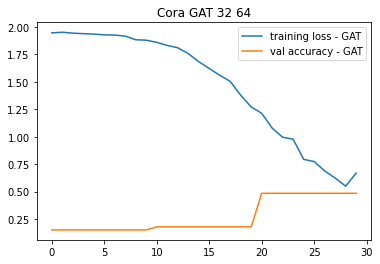

In [ ]:
args={'model_type': 'GAT', 'dataset': 'Cora', 'num_layers': 2, 'heads': 2, 
         'batch_size': 32, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 30, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
if args["dataset"] == 'Cora':
  dataset=Planetoid(root=".", name="Cora")
else: 
  dataset=Planetoid(root=".", name="Citeseer")
test_accs, losses, model_GATConv = train(dataset, args) 
print("Maximum accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))
test_acc=testacc(model_GATConv,dataset)
print(test_acc)
model_GATConv.minmaxAttention()
plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
plt.plot(losses, label="training loss" + " - " + args["model_type"])
plt.plot(test_accs, label="val accuracy" + " - " + args["model_type"])
plt.legend()
plt.show()

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


copy of training...


In [ ]:
'''
import time

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset
from torch_geometric.datasets import Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.nn as pyg_nn

import matplotlib.pyplot as plt


def train(dataset, args):
    
    print("Node task. test set size:", np.sum(dataset[0]['train_mask'].numpy()))
    test_loader = loader = DataLoader(dataset, batch_size=args["batch_size"], shuffle=True)

    # build model
    model = GraphModel(dataset.num_node_features, args["hidden_dim"], dataset.num_classes,args,False)
    filter_fn = filter(lambda p : p.requires_grad, model.parameters())
    opt = optim.Adam(filter_fn, lr=args["lr"], weight_decay=args["weight_decay"])
    #scheduler = optim.lr_scheduler.StepLR(opt, step_size=args["opt_decay_step"], gamma=args["opt_decay_rate"])
    # train
    losses = []
    test_accs = []
    train_acc=[]
    for epoch in range(args["epochs"]):
        total_loss = 0
        model.train()
        train_accuracies=0
        for batch in loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            pred = pred[batch.train_mask]
            label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs

            train_pred=pred.argmax(dim=1)
            correct = train_pred.eq(label).sum().item()
            total =torch.sum(batch.train_mask).item()
            train_accuracies=correct/total
            if epoch%10==0:
              train_acc.append(train_accuracies)
        total_loss /= len(loader.dataset)
        losses.append(total_loss)

        if epoch % 10 == 0:
          test_acc = test(test_loader, model)
          test_accs.append(test_acc)
         
          print("Epoch ", epoch, "Loss: ", total_loss, "Train Acc: ", train_accuracies, "Test Acc.: ", test_acc)
        else:
          test_accs.append(test_accs[-1])
    return test_accs, losses, model

def test(loader, model, is_validation=True):
    model.eval()
    correct = 0
    for data in loader:
        with torch.no_grad():
            # max(dim=1) returns values, indices tuple; only need indices
            pred = model(data).max(dim=1)[1]
            label = data.y

        mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        pred = pred[mask]
        label = data.y[mask]
            
        correct += pred.eq(label).sum().item()

    total = 0
    for data in loader.dataset:
        total += torch.sum(data.val_mask if is_validation else data.test_mask).item()
    return correct / total
  
class objectview(object):
    def __init__(self, d):
        self.__dict__ = d
'''

##Visualization functions

In [64]:
def accuracy(pred_y,y):
  return ((pred_y == y).sum() / len(y)).item()

In [65]:
from torch_geometric.utils import degree
def generateGraph(model):
  dataset = Planetoid(root='.', name="Cora")
  
  data=dataset[0]
  model.embedding=True
# Get model's classifications
  out = model(data)

# Calculate the degree of each node
  degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
  accuracies = []
  sizes = []

# Accuracy for degrees between 0 and 5
  for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))

# Accuracy for degrees > 5
  mask = np.where(degrees > 5)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Bar plot
  fig, ax = plt.subplots(figsize=(18, 9))
  plt.ylim(0, 1)
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Accuracy score')
  plt.bar(['0','1','2','3','4','5','>5'],accuracies,color=(0.2, 0.4, 0.6, 0.6))
  for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color=(0.2, 0.4, 0.6, 0.6))
  for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],ha='center', color='white')
  plt.show()

In [66]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [67]:
def dimension_reduction(model: nn.Module):
  """
    Args:
      model: model object for generating features
    
    Return:
      pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2', and 'labels' as a column
  """
    ## ------ Begin Solution ------ ##
  model.emb=True
  dataset = Planetoid(root='.', name="Cora")
  data=dataset[0]
  emb = (model.generate_emb(data)).detach().numpy()
  #emb=emb[data.val_mask]
  y=data.y[data.val_mask]
  t=TSNE(n_components=2).fit_transform(emb)[data["val_mask"]]
  data = {'dimension 1':t[:,0], 'dimension 2':t[:,1], 'labels':y}
  df = pd.DataFrame(data)
  plt.scatter(df['dimension 1'], df['dimension 2'], c=df['labels'])
  plt.show()


## Parameter Tuning
try combination of different datasets, different batch size and different hidden_dim, to search the best combination

{'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 2, 'heads': 1, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 200, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 0.005, 'lr': 0.005}
Node task. test set size: 140
heads
1
Epoch  0 Loss:  1.9572924375534058 Train Acc:  0.2 Test Acc.:  0.156


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch  10 Loss:  1.9152969121932983 Train Acc:  0.2571428571428571 Test Acc.:  0.254
Epoch  20 Loss:  1.8078370094299316 Train Acc:  0.30714285714285716 Test Acc.:  0.346
Epoch  30 Loss:  1.622813105583191 Train Acc:  0.37142857142857144 Test Acc.:  0.422
Epoch  40 Loss:  1.4488064050674438 Train Acc:  0.4714285714285714 Test Acc.:  0.494
Epoch  50 Loss:  1.337599754333496 Train Acc:  0.5071428571428571 Test Acc.:  0.588
Epoch  60 Loss:  1.114382266998291 Train Acc:  0.6071428571428571 Test Acc.:  0.638
Epoch  70 Loss:  1.0517947673797607 Train Acc:  0.6 Test Acc.:  0.614
Epoch  80 Loss:  1.0931613445281982 Train Acc:  0.6 Test Acc.:  0.61
Epoch  90 Loss:  1.079393744468689 Train Acc:  0.6142857142857143 Test Acc.:  0.68
Epoch  100 Loss:  1.0395830869674683 Train Acc:  0.6428571428571429 Test Acc.:  0.678
Epoch  110 Loss:  0.9071348905563354 Train Acc:  0.6928571428571428 Test Acc.:  0.676
Epoch  120 Loss:  1.0578795671463013 Train Acc:  0.6071428571428571 Test Acc.:  0.69
Epoch  130 L

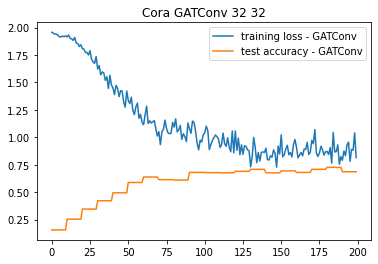

{'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 2, 'heads': 2, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 200, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 0.005, 'lr': 0.005}
Node task. test set size: 140
heads
2
Epoch  0 Loss:  1.945931077003479 Train Acc:  0.17857142857142858 Test Acc.:  0.276
Epoch  10 Loss:  1.855019450187683 Train Acc:  0.20714285714285716 Test Acc.:  0.238
Epoch  20 Loss:  1.636755347251892 Train Acc:  0.39285714285714285 Test Acc.:  0.558
Epoch  30 Loss:  1.2671847343444824 Train Acc:  0.5571428571428572 Test Acc.:  0.596
Epoch  40 Loss:  0.8589010834693909 Train Acc:  0.6928571428571428 Test Acc.:  0.648
Epoch  50 Loss:  0.9184550642967224 Train Acc:  0.6357142857142857 Test Acc.:  0.714
Epoch  60 Loss:  0.6744674444198608 Train Acc:  0.8 Test Acc.:  0.712
Epoch  70 Loss:  0.5645279288291931 Train Acc:  0.8 Test Acc.:  0.716
Epoch  80 Loss:  0.5408885478973389 Train Acc:  0.8357142857142857 Test Acc.: 

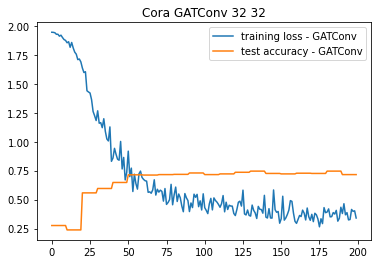

{'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 2, 'heads': 4, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 200, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 0.005, 'lr': 0.005}
Node task. test set size: 140
heads
4
Epoch  0 Loss:  1.9585137367248535 Train Acc:  0.15714285714285714 Test Acc.:  0.09
Epoch  10 Loss:  1.8500787019729614 Train Acc:  0.35714285714285715 Test Acc.:  0.3
Epoch  20 Loss:  1.2233028411865234 Train Acc:  0.5571428571428572 Test Acc.:  0.426
Epoch  30 Loss:  0.6177721619606018 Train Acc:  0.8142857142857143 Test Acc.:  0.678
Epoch  40 Loss:  0.5348996520042419 Train Acc:  0.8214285714285714 Test Acc.:  0.726
Epoch  50 Loss:  0.2104692906141281 Train Acc:  0.9571428571428572 Test Acc.:  0.744
Epoch  60 Loss:  0.22996188700199127 Train Acc:  0.9357142857142857 Test Acc.:  0.718
Epoch  70 Loss:  0.23058582842350006 Train Acc:  0.9214285714285714 Test Acc.:  0.728
Epoch  80 Loss:  0.1409485936164856 Train Acc: 

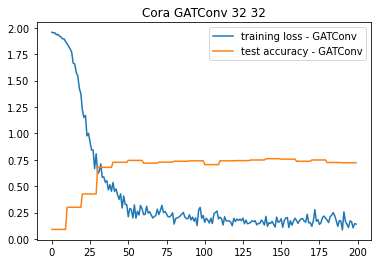

{'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 2, 'heads': 8, 'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 200, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 0.005, 'lr': 0.005}
Node task. test set size: 140
heads
8
Epoch  0 Loss:  1.950778603553772 Train Acc:  0.15 Test Acc.:  0.074
Epoch  10 Loss:  1.7113829851150513 Train Acc:  0.40714285714285714 Test Acc.:  0.592
Epoch  20 Loss:  0.6904600858688354 Train Acc:  0.8285714285714286 Test Acc.:  0.738
Epoch  30 Loss:  0.1929258555173874 Train Acc:  0.95 Test Acc.:  0.752
Epoch  40 Loss:  0.10048199445009232 Train Acc:  0.9857142857142858 Test Acc.:  0.734
Epoch  50 Loss:  0.1372150331735611 Train Acc:  0.9642857142857143 Test Acc.:  0.736
Epoch  60 Loss:  0.16331596672534943 Train Acc:  0.9642857142857143 Test Acc.:  0.738
Epoch  70 Loss:  0.10041411221027374 Train Acc:  0.9928571428571429 Test Acc.:  0.756
Epoch  80 Loss:  0.0692637711763382 Train Acc:  0.9928571428571429 Test A

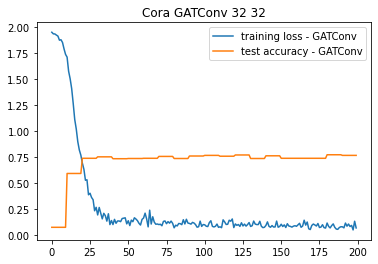

{'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 2, 'heads': 1, 'batch_size': 64, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 200, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 0.005, 'lr': 0.005}
Node task. test set size: 140
heads
1
Epoch  0 Loss:  1.951142430305481 Train Acc:  0.1 Test Acc.:  0.172
Epoch  10 Loss:  1.9143999814987183 Train Acc:  0.21428571428571427 Test Acc.:  0.224
Epoch  20 Loss:  1.7598865032196045 Train Acc:  0.2571428571428571 Test Acc.:  0.25
Epoch  30 Loss:  1.6815667152404785 Train Acc:  0.32857142857142857 Test Acc.:  0.41
Epoch  40 Loss:  1.4440230131149292 Train Acc:  0.4714285714285714 Test Acc.:  0.488
Epoch  50 Loss:  1.3777379989624023 Train Acc:  0.45 Test Acc.:  0.564
Epoch  60 Loss:  1.1760002374649048 Train Acc:  0.5428571428571428 Test Acc.:  0.58
Epoch  70 Loss:  1.087977409362793 Train Acc:  0.6142857142857143 Test Acc.:  0.61
Epoch  80 Loss:  1.1040897369384766 Train Acc:  0.5571428571428572 Test Acc.:  0.

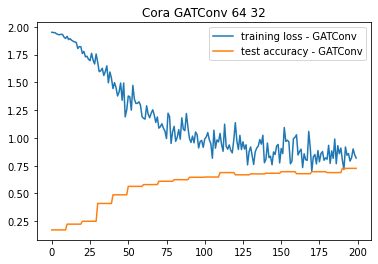

{'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 2, 'heads': 2, 'batch_size': 64, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 200, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 0.005, 'lr': 0.005}
Node task. test set size: 140
heads
2
Epoch  0 Loss:  1.962732195854187 Train Acc:  0.12857142857142856 Test Acc.:  0.196
Epoch  10 Loss:  1.8813408613204956 Train Acc:  0.2571428571428571 Test Acc.:  0.328
Epoch  20 Loss:  1.6260700225830078 Train Acc:  0.4714285714285714 Test Acc.:  0.48
Epoch  30 Loss:  1.2907335758209229 Train Acc:  0.5357142857142857 Test Acc.:  0.568
Epoch  40 Loss:  0.8898856043815613 Train Acc:  0.6928571428571428 Test Acc.:  0.626
Epoch  50 Loss:  0.737088143825531 Train Acc:  0.7428571428571429 Test Acc.:  0.708
Epoch  60 Loss:  0.6558813452720642 Train Acc:  0.7785714285714286 Test Acc.:  0.7
Epoch  70 Loss:  0.4639865756034851 Train Acc:  0.8571428571428571 Test Acc.:  0.714
Epoch  80 Loss:  0.421499103307724 Train Acc:  0.857

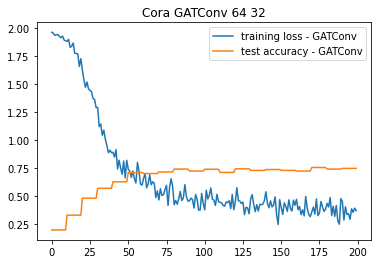

{'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 2, 'heads': 4, 'batch_size': 64, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 200, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 0.005, 'lr': 0.005}
Node task. test set size: 140
heads
4
Epoch  0 Loss:  1.9568307399749756 Train Acc:  0.15 Test Acc.:  0.154
Epoch  10 Loss:  1.7999305725097656 Train Acc:  0.35714285714285715 Test Acc.:  0.366
Epoch  20 Loss:  1.131490707397461 Train Acc:  0.6 Test Acc.:  0.616
Epoch  30 Loss:  0.5900737643241882 Train Acc:  0.8071428571428572 Test Acc.:  0.666
Epoch  40 Loss:  0.3791153132915497 Train Acc:  0.9 Test Acc.:  0.71
Epoch  50 Loss:  0.3451845049858093 Train Acc:  0.9 Test Acc.:  0.76
Epoch  60 Loss:  0.2842967212200165 Train Acc:  0.9142857142857143 Test Acc.:  0.738
Epoch  70 Loss:  0.18213166296482086 Train Acc:  0.9642857142857143 Test Acc.:  0.73
Epoch  80 Loss:  0.14714889228343964 Train Acc:  0.9785714285714285 Test Acc.:  0.742
Epoch  90 Loss:  0.2751

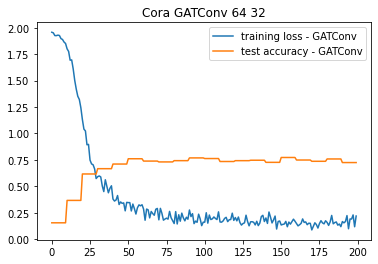

{'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 2, 'heads': 8, 'batch_size': 64, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 200, 'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 'weight_decay': 0.005, 'lr': 0.005}
Node task. test set size: 140
heads
8
Epoch  0 Loss:  1.9508004188537598 Train Acc:  0.12857142857142856 Test Acc.:  0.156
Epoch  10 Loss:  1.696250081062317 Train Acc:  0.45 Test Acc.:  0.574
Epoch  20 Loss:  0.6075611114501953 Train Acc:  0.7928571428571428 Test Acc.:  0.76
Epoch  30 Loss:  0.22263877093791962 Train Acc:  0.9285714285714286 Test Acc.:  0.744
Epoch  40 Loss:  0.18517881631851196 Train Acc:  0.9571428571428572 Test Acc.:  0.746


KeyboardInterrupt: ignored

In [ ]:
def main():
  args={'model_type': 'GATConv', 'dataset': 'cora', 'num_layers': 2, 'heads': 2, 
         'batch_size': 32, 'hidden_dim': 32, 'dropout': 0.6, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
  for ds in ['Cora','Citeseer']:
    for mt in['GATConv','GAT']:
      for hd in [32,64]:
        for bs in[32,64]:
          for heads in [1,2,4,8]:
            args["model_type"]=mt
            args["dataset"]=ds
            args["batch_size"]=bs
            args["hidden_dim"]=hd
            args["heads"]=heads

            print(args)
            if args["dataset"] == 'Cora':
              dataset=Planetoid(root=".", name="Cora")
            else: 
              dataset=Planetoid(root=".", name="Citeseer")
            test_accs, losses, model = train(dataset, args) 
            print("Maximum accuracy: {0}".format(max(test_accs)))
            print("Minimum loss: {0}".format(min(losses)))
            plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
            plt.plot(losses, label="training loss" + " - " + args["model_type"])
            plt.plot(test_accs, label="test accuracy" + " - " + args["model_type"])
            plt.legend()
            plt.show()
    
if __name__ == '__main__':
    main()

##GCN with node normalised, tune with the same setting

###GCN normalised, cora

Node task. test set size: 140
heads
1


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Maximum accuracy: 0.762
Minimum loss: 0.00587097741663456
0.746999979019165


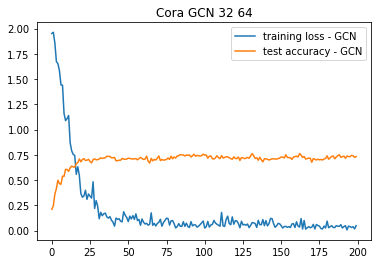

Node task. test set size: 140
heads
1

Maximum accuracy: 0.764
Minimum loss: 0.011395471170544624
0.7170000076293945


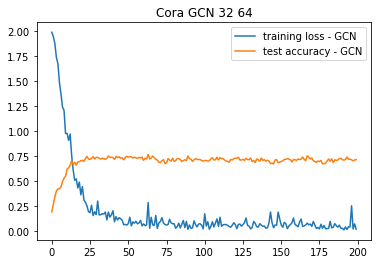

Node task. test set size: 140
heads
1

Maximum accuracy: 0.76
Minimum loss: 0.01323088351637125
0.7360000014305115


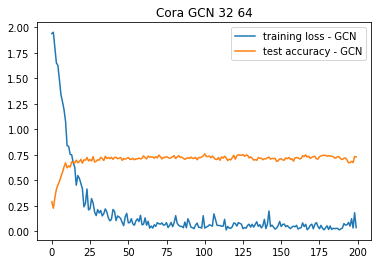

Node task. test set size: 140
heads
1

Maximum accuracy: 0.768
Minimum loss: 0.013932893984019756
0.7590000033378601


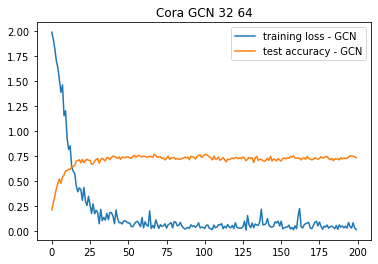

Node task. test set size: 140
heads
1

Maximum accuracy: 0.764
Minimum loss: 0.01059974916279316
0.7310000061988831


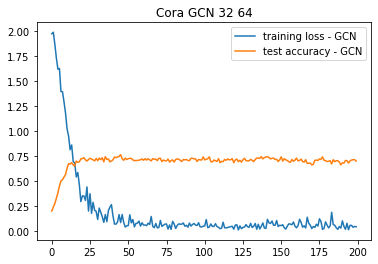

In [32]:
acc_GCNnorm=[]
best_GCNnorm=0
for count in range(5):
  args={'model_type': 'GCN', 'dataset': 'Cora', 'num_layers': 2, 'heads': 1, 
         'batch_size': 32, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
  if args["dataset"] == 'Cora':
    dataset=Planetoid(root=".", name="Cora")
  else: 
    dataset=Planetoid(root=".", name="Citeseer")
  test_accs, losses, model = train(dataset, args) 
  print("Maximum accuracy: {0}".format(max(test_accs)))
  print("Minimum loss: {0}".format(min(losses)))
  plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
  plt.plot(losses, label="training loss" + " - " + args["model_type"])
  plt.plot(test_accs, label="test accuracy" + " - " + args["model_type"])
  test_acc=testacc(model,dataset)
  if test_acc>best_GCNnorm:
    acc_GCNnorm=test_accs
    best_GCNnorm=test_acc
  print(test_acc)
 # generateGraph(model)
  #dimension_reduction(model)
  plt.legend()
  plt.show()


###GCN normalised, Citeseer

Processing...
Done!
/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 120
heads
1

Maximum accuracy: 0.68
Minimum loss: 0.015265745110809803
0.6159999966621399


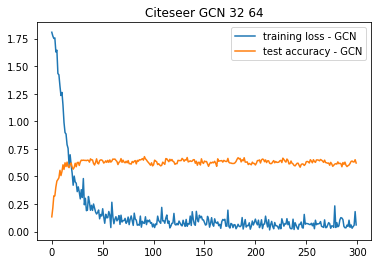

Node task. test set size: 120
heads
1

Maximum accuracy: 0.676
Minimum loss: 0.006582929752767086
0.6620000004768372


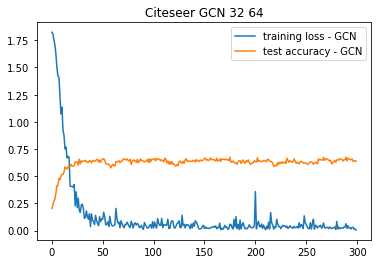

Node task. test set size: 120
heads
1

Maximum accuracy: 0.686
Minimum loss: 0.003023724537342787
0.628000020980835


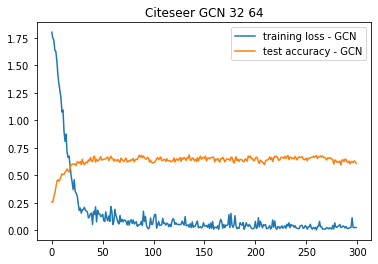

Node task. test set size: 120
heads
1

Maximum accuracy: 0.648
Minimum loss: 0.005625011399388313
0.6010000109672546


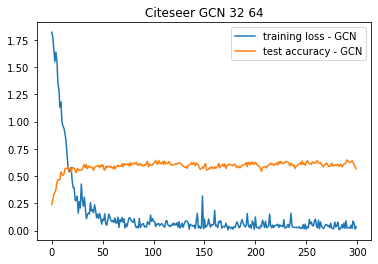

Node task. test set size: 120
heads
1

Maximum accuracy: 0.696
Minimum loss: 0.005746879614889622
0.5809999704360962


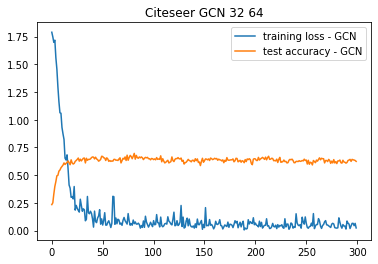

In [33]:
acc_GCNnorm_Citeseer=[]
best_GCNnorm_Citeseer=0
for count in range(5):
  args={'model_type': 'GCN', 'dataset': 'Citeseer', 'num_layers': 2, 'heads': 1, 
         'batch_size': 32, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 300, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
  if args["dataset"] == 'Cora':
    dataset=Planetoid(root=".", name="Cora")
  else: 
    dataset=Planetoid(root=".", name="Citeseer",split="random")
  test_accs, losses, model = train(dataset, args) 
  print("Maximum accuracy: {0}".format(max(test_accs)))
  print("Minimum loss: {0}".format(min(losses)))
  plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
  plt.plot(losses, label="training loss" + " - " + args["model_type"])
  plt.plot(test_accs, label="test accuracy" + " - " + args["model_type"])
  test_acc=testacc(model,dataset)
  if test_acc>best_GCNnorm_Citeseer:
    acc_GCNnorm_Citeseer=test_accs
    best_GCNnorm_Citeseer=test_acc
  print(test_acc)
  #generateGraph(model)
  #dimension_reduction(model)
  plt.legend()
  plt.show()

##GCN with sum aggregation, not normalised

###cora

Node task. test set size: 140
heads
1

Maximum accuracy: 0.746
Minimum loss: 0.027386849746108055
0.7279999852180481


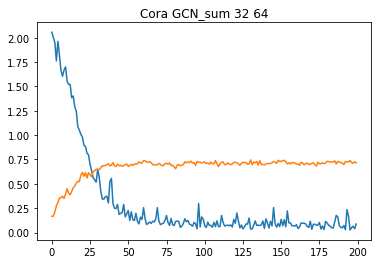

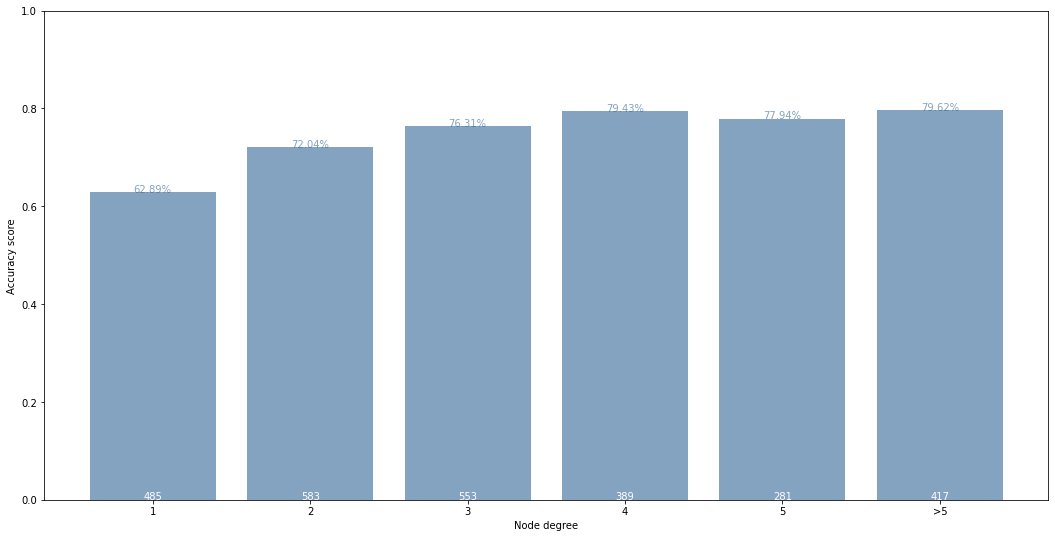

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


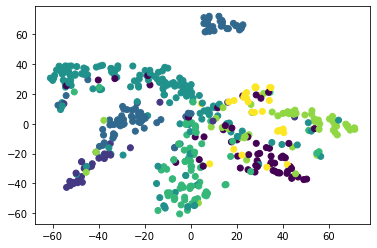

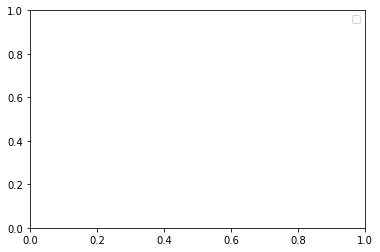

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 140
heads
1

Maximum accuracy: 0.744
Minimum loss: 0.028135882690548897
0.6949999928474426


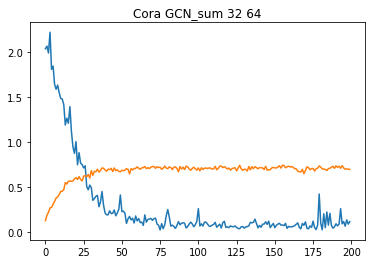

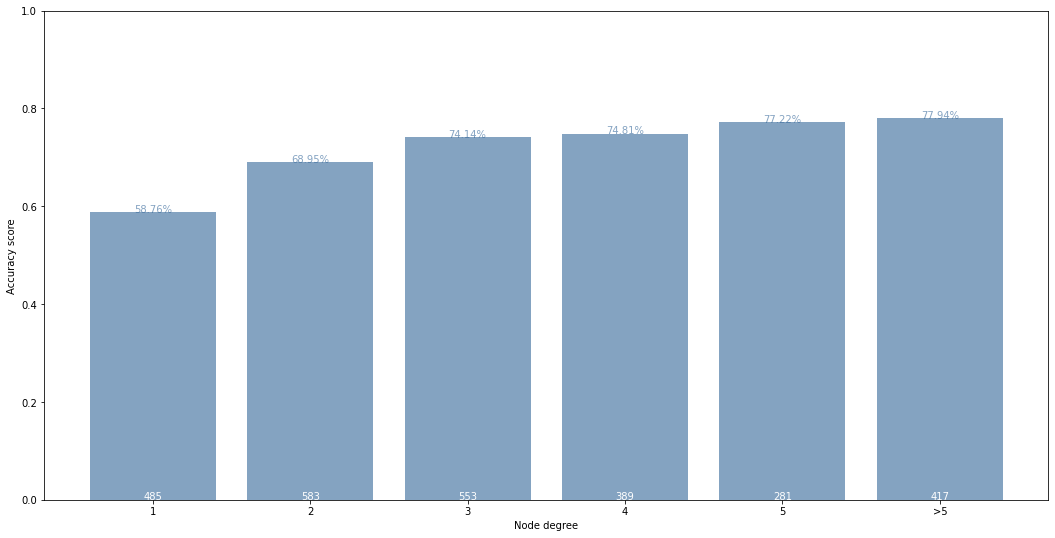

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


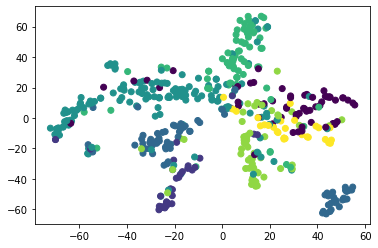

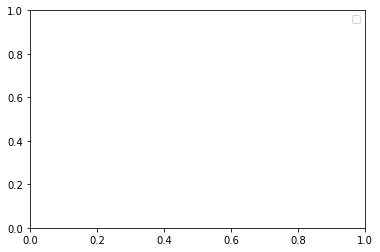

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 140
heads
1

Maximum accuracy: 0.742
Minimum loss: 0.030321428552269936
0.6990000009536743


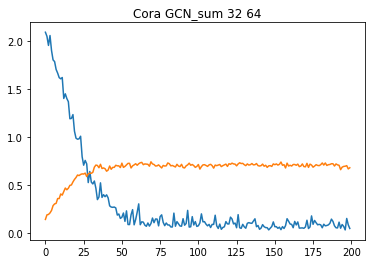

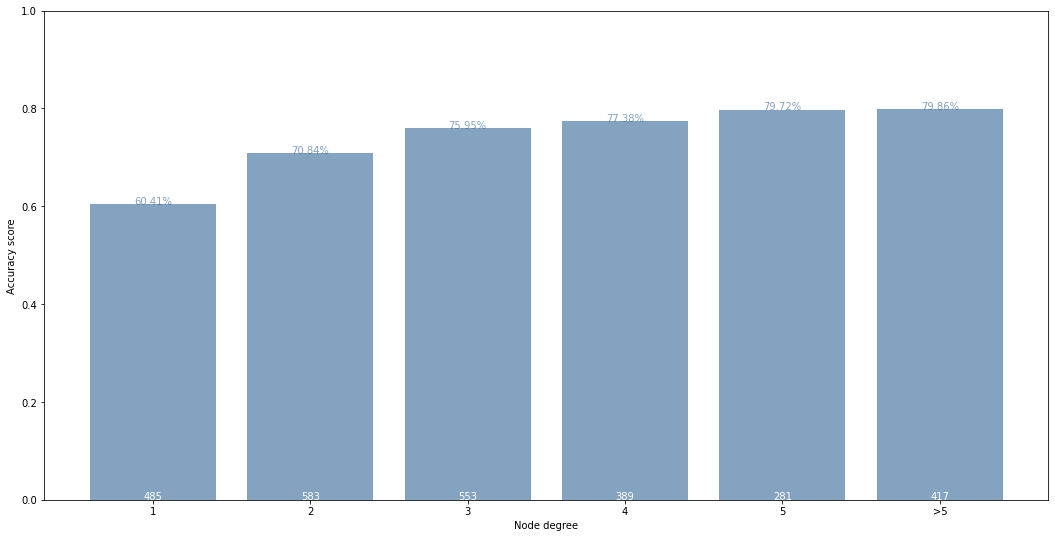

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


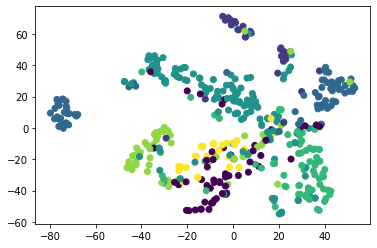

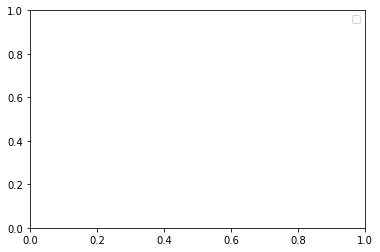

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 140
heads
1

Maximum accuracy: 0.746
Minimum loss: 0.028967032209038734
0.7260000109672546


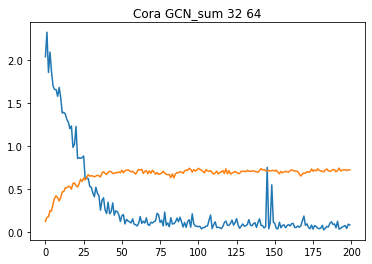

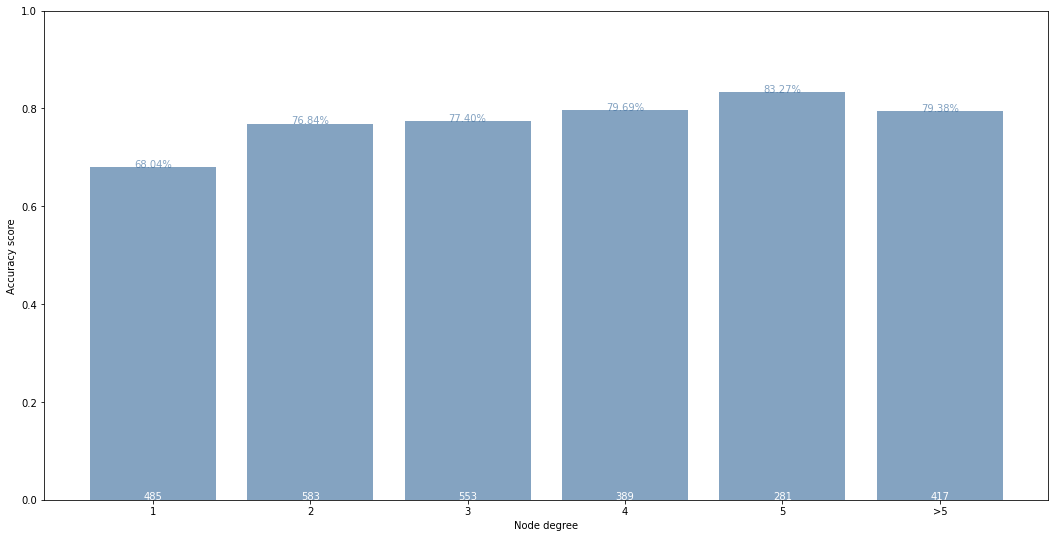

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


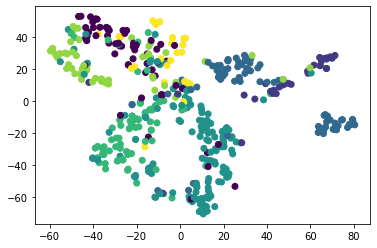

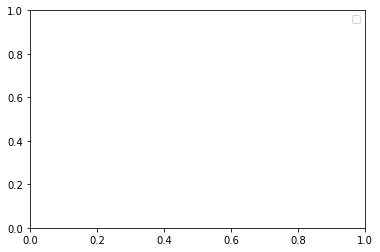

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 140
heads
1

Maximum accuracy: 0.762
Minimum loss: 0.030869068577885628
0.7440000176429749


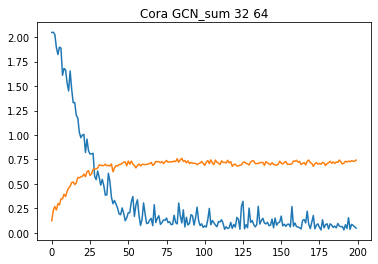

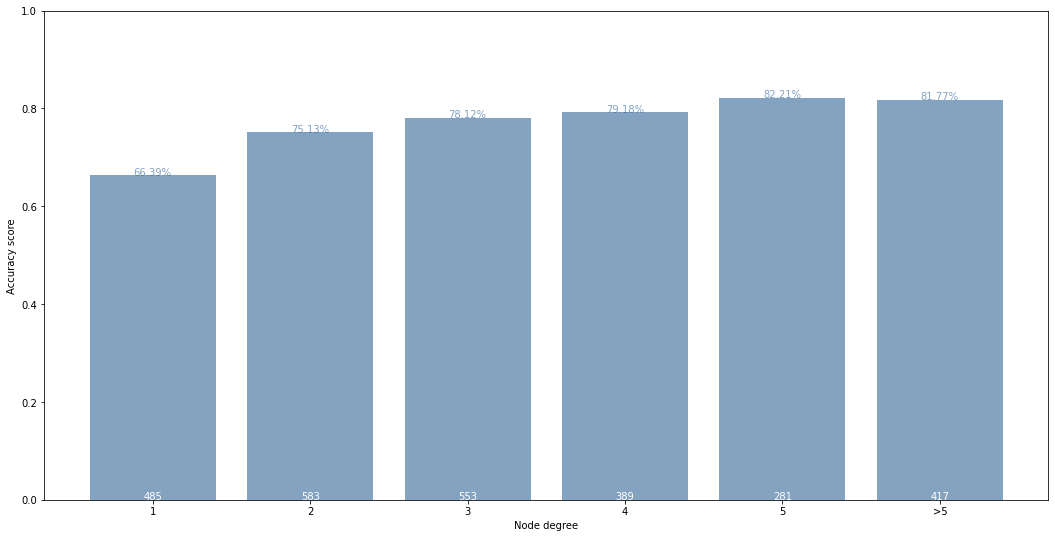

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


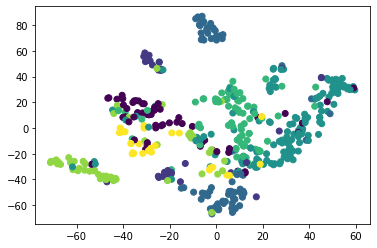

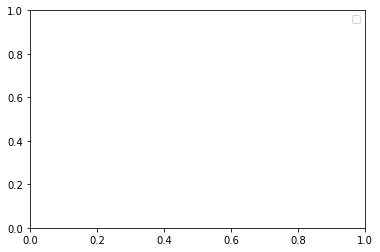

In [34]:
acc_GCNsum=[]
best_GCNsum=0
for count in range(5):
  args={'model_type': 'GCN_sum', 'dataset': 'Cora', 'num_layers': 2, 'heads': 1, 
         'batch_size': 32, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
  if args["dataset"] == 'Cora':
    dataset=Planetoid(root=".", name="Cora")
  else: 
    dataset=Planetoid(root=".", name="Citeseer")
  test_accs, losses, model = train(dataset, args) 
  print("Maximum accuracy: {0}".format(max(test_accs)))
  print("Minimum loss: {0}".format(min(losses)))
  plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
  plt.plot(losses, label="training loss" + " - " + args["model_type"])
  plt.plot(test_accs, label="test accuracy" + " - " + args["model_type"])
  test_acc=testacc(model,dataset)
  if test_acc>best_GCNsum:
    acc_GCNsum=test_accs
    best_GCNsum=test_acc
  print(test_acc)
  generateGraph(model)
  dimension_reduction(model)
  plt.legend()
  plt.show()

###Citeseer

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 120
heads
1

Maximum accuracy: 0.604
Minimum loss: 0.013729100115597248
0.5720000267028809


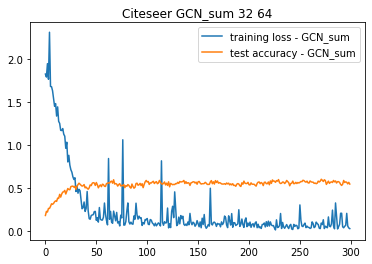

Node task. test set size: 120
heads
1

Maximum accuracy: 0.602
Minimum loss: 0.020727526396512985
0.5630000233650208


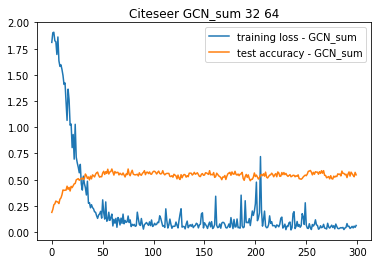

Node task. test set size: 120
heads
1

Maximum accuracy: 0.648
Minimum loss: 0.01866018958389759
0.6010000109672546


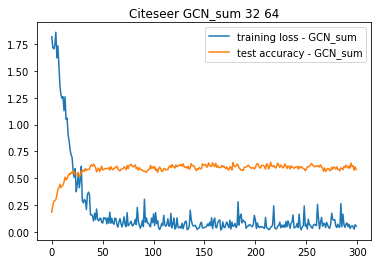

Node task. test set size: 120
heads
1

Maximum accuracy: 0.624
Minimum loss: 0.01629665121436119
0.5720000267028809


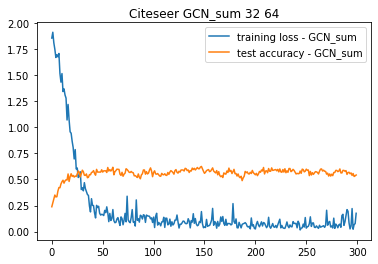

Node task. test set size: 120
heads
1

Maximum accuracy: 0.648
Minimum loss: 0.015490994788706303
0.6309999823570251


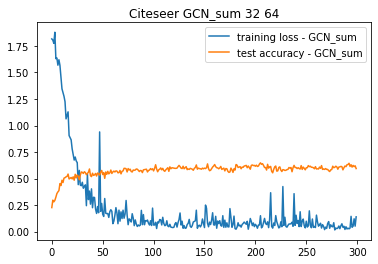

In [35]:
acc_GCNsum_Citeseer=[]
best_GCNsum_Citeseer=0
for count in range(5):
  args={'model_type': 'GCN_sum', 'dataset': 'Citeseer', 'num_layers': 2, 'heads': 1, 
         'batch_size': 32, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 300, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
  if args["dataset"] == 'Cora':
    dataset=Planetoid(root=".", name="Cora")
  else: 
    dataset=Planetoid(root=".", name="Citeseer",split="random")
  test_accs, losses, model = train(dataset, args) 
  print("Maximum accuracy: {0}".format(max(test_accs)))
  print("Minimum loss: {0}".format(min(losses)))
  plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
  plt.plot(losses, label="training loss" + " - " + args["model_type"])
  plt.plot(test_accs, label="test accuracy" + " - " + args["model_type"])
  test_acc=testacc(model,dataset)
  if test_acc>best_GCNsum_Citeseer:
    acc_GCNsum_Citeseer=test_accs
    best_GCNsum_Citeseer=test_acc
  print(test_acc)
  #generateGraph(model)
  #dimension_reduction(model)
  plt.legend()
  plt.show()

##GAT attention aggregation

###cora

Node task. test set size: 140
heads
8

Maximum accuracy: 0.76
Minimum loss: 0.5199192762374878
0.7400000095367432


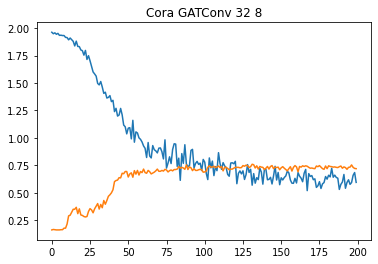

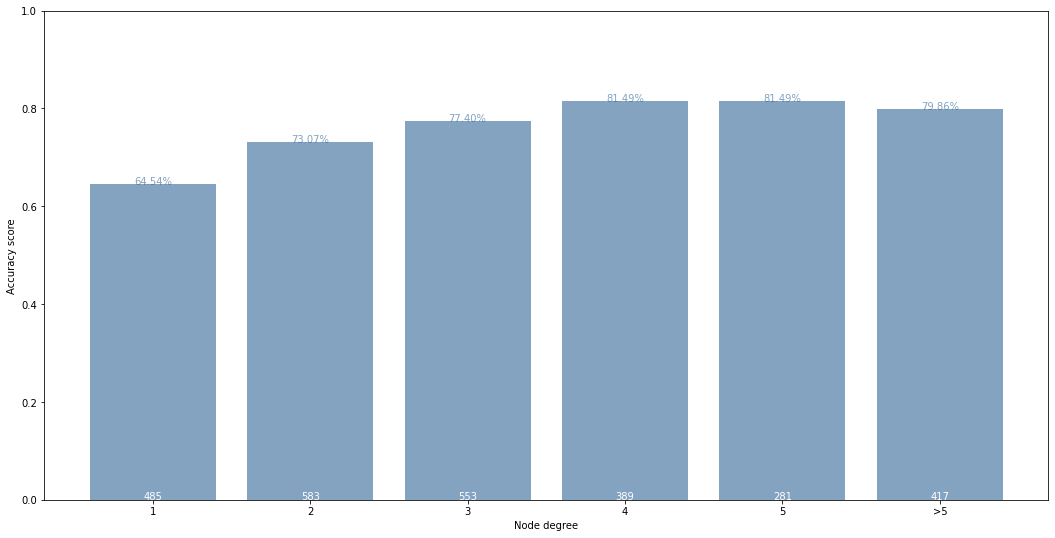

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


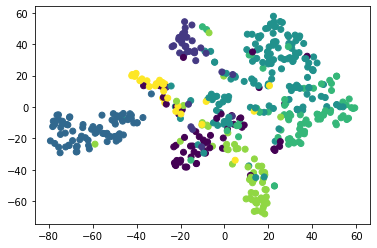

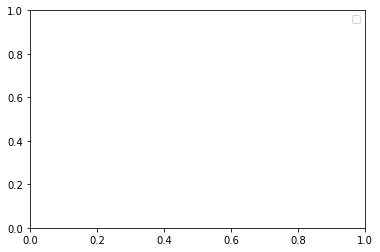

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 140
heads
8

Maximum accuracy: 0.768
Minimum loss: 0.5544779896736145
0.7419999837875366


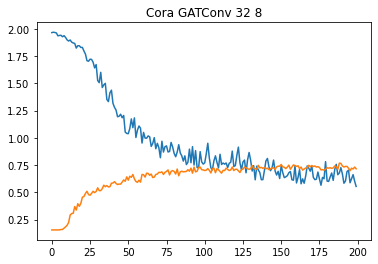

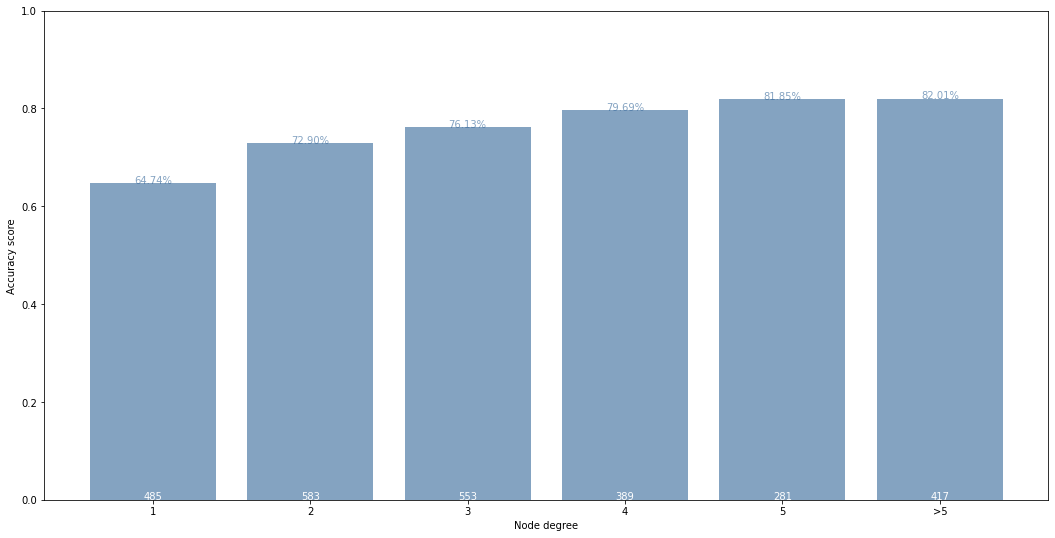

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


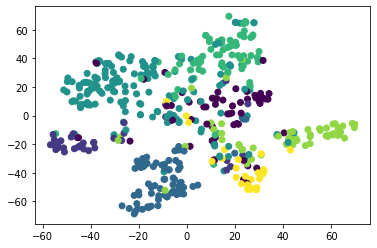

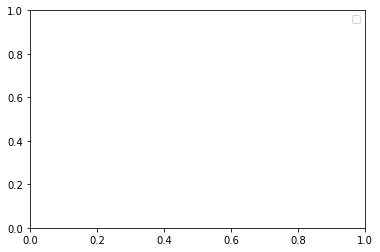

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 140
heads
8

Maximum accuracy: 0.76
Minimum loss: 0.5737261772155762
0.7350000143051147


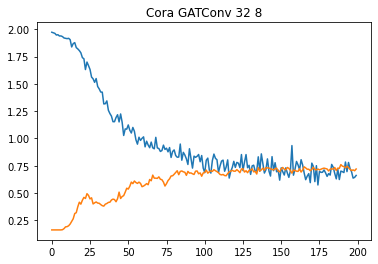

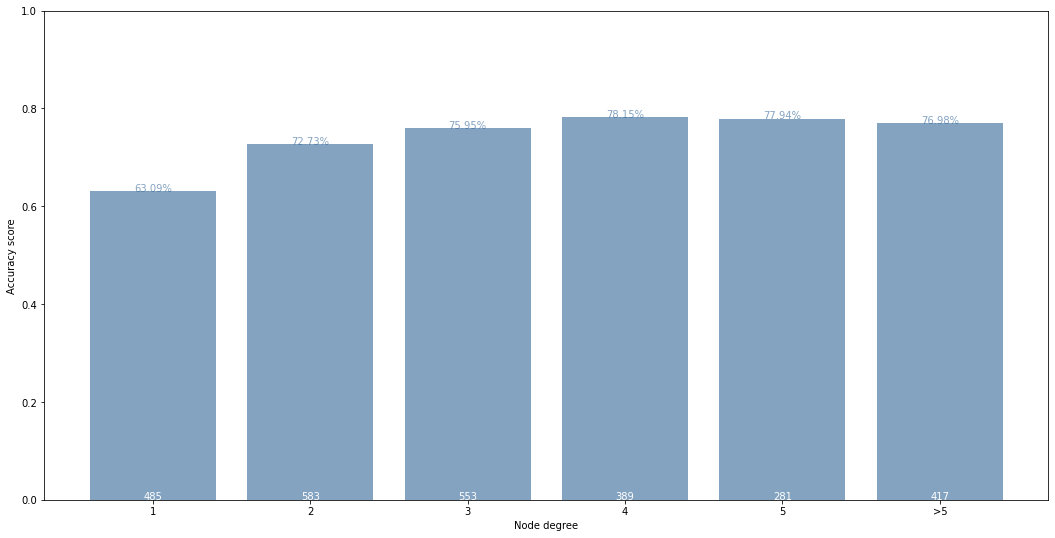

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


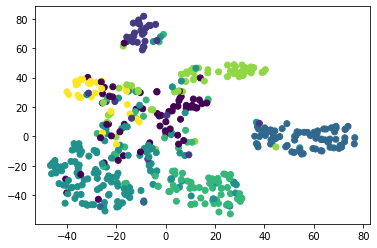

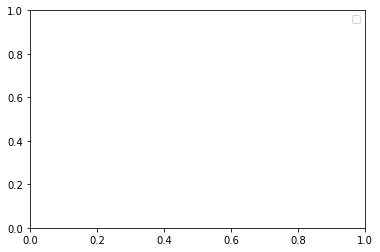

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 140
heads
8

Maximum accuracy: 0.686
Minimum loss: 0.6397810578346252
0.6850000023841858


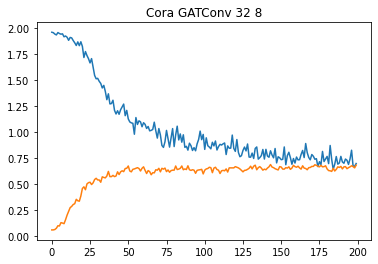

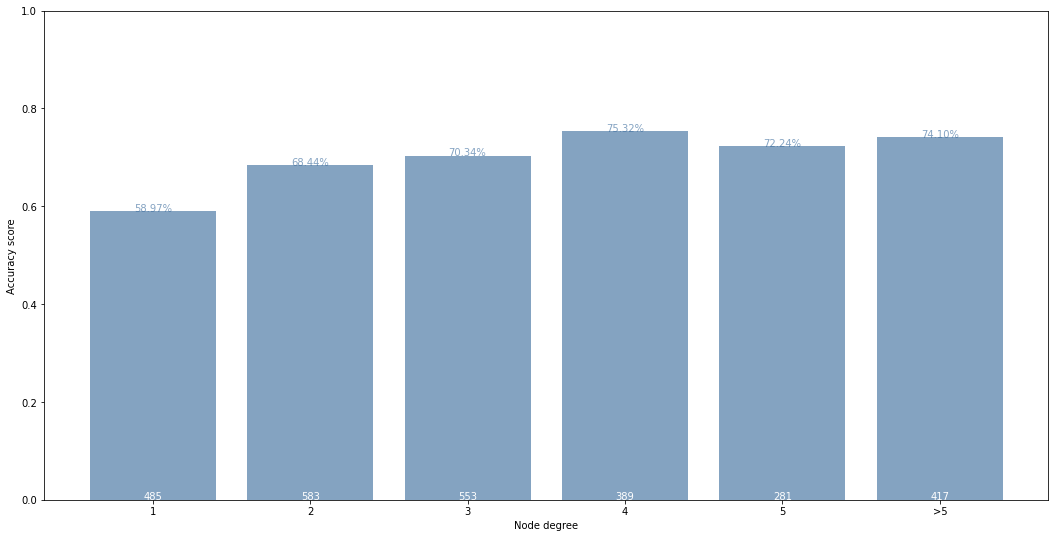

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


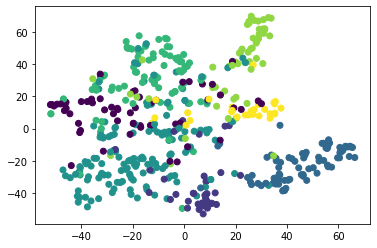

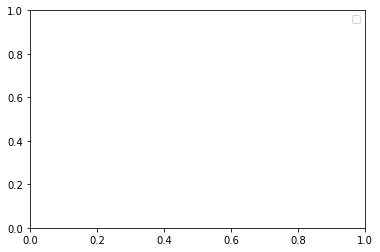

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 140
heads
8

Maximum accuracy: 0.762
Minimum loss: 0.5658233761787415
0.7390000224113464


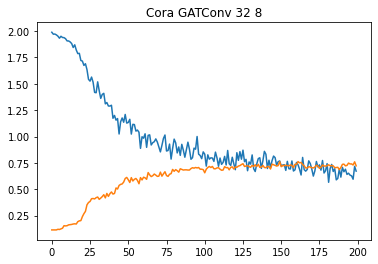

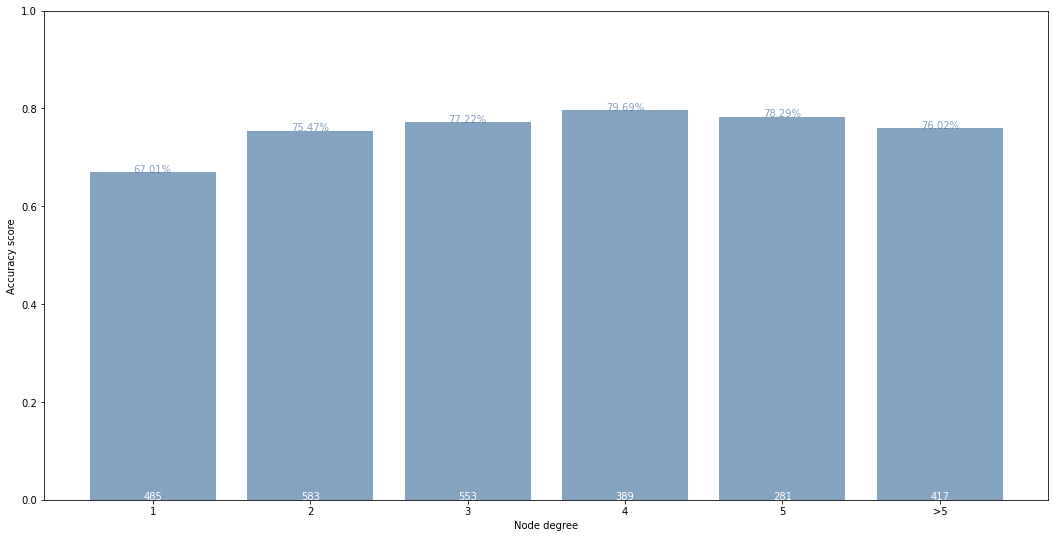

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


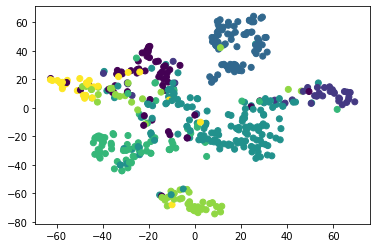

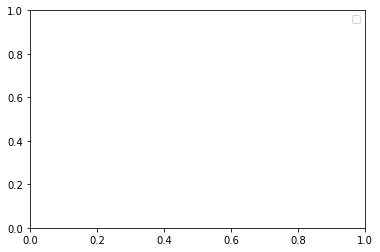

In [50]:
acc_GAT=[]
best_GAT=0
for count in range(5):
  args={'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 2, 'heads': 8, 
         'batch_size': 32, 'hidden_dim': 8, 'dropout': 0.6, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
  if args["dataset"] == 'Cora':
    dataset=Planetoid(root=".", name="Cora")
  else: 
    dataset=Planetoid(root=".", name="Citeseer")
  test_accs, losses, model = train(dataset, args) 
  print("Maximum accuracy: {0}".format(max(test_accs)))
  print("Minimum loss: {0}".format(min(losses)))
  plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
  plt.plot(losses, label="training loss" + " - " + args["model_type"])
  plt.plot(test_accs, label="test accuracy" + " - " + args["model_type"])
  test_acc=testacc(model,dataset)
  if test_acc>best_GAT:
    acc_GAT=test_accs
    best_GAT=test_acc
  print(test_acc)
  generateGraph(model)
  dimension_reduction(model)
  plt.legend()
  plt.show()


###citeseer

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Node task. test set size: 120
heads
8

Maximum accuracy: 0.65
Minimum loss: 0.43871352076530457
0.6370000243186951


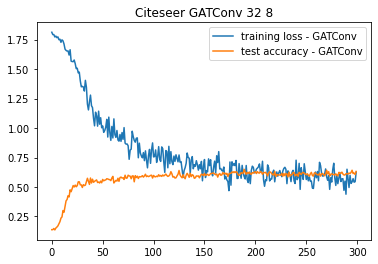

Node task. test set size: 120
heads
8

Maximum accuracy: 0.716
Minimum loss: 0.47040900588035583
0.6840000152587891


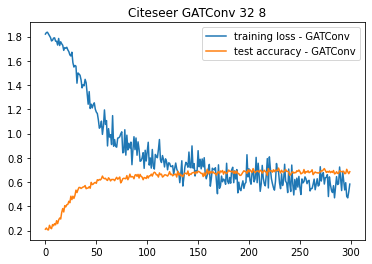

Node task. test set size: 120
heads
8

Maximum accuracy: 0.682
Minimum loss: 0.4327159821987152
0.6349999904632568


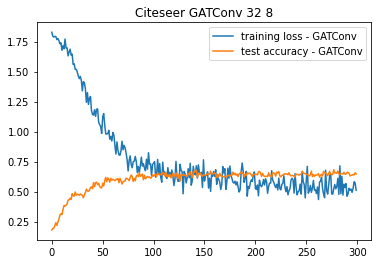

Node task. test set size: 120
heads
8

Maximum accuracy: 0.644
Minimum loss: 0.4390479624271393
0.6309999823570251


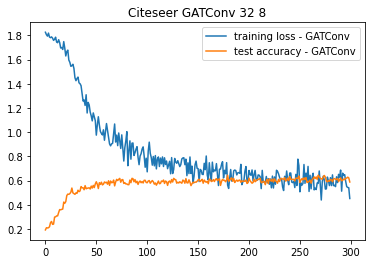

Node task. test set size: 120
heads
8

Maximum accuracy: 0.632
Minimum loss: 0.3812890648841858
0.6769999861717224


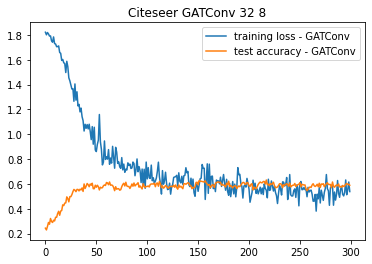

In [51]:
acc_GAT_Citeseer=[]
best_GAT_Citeseer=0
for count in range(5):
  args={'model_type': 'GATConv', 'dataset': 'Citeseer', 'num_layers': 2, 'heads': 8, 
         'batch_size': 32, 'hidden_dim': 8, 'dropout': 0.6, 'epochs': 300, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
  if args["dataset"] == 'Cora':
    dataset=Planetoid(root=".", name="Cora")
  else: 
    dataset=Planetoid(root=".", name="Citeseer",split="random")
  test_accs, losses, model = train(dataset, args) 
  print("Maximum accuracy: {0}".format(max(test_accs)))
  print("Minimum loss: {0}".format(min(losses)))
  plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
  plt.plot(losses, label="training loss" + " - " + args["model_type"])
  plt.plot(test_accs, label="test accuracy" + " - " + args["model_type"])
  test_acc=testacc(model,dataset)
  if test_acc>best_GAT_Citeseer:
    acc_GAT_Citeseer=test_accs
    best_GAT_Citeseer=test_acc
  print(test_acc)
  #generateGraph(model)
 # dimension_reduction(model)
  plt.legend()
  plt.show()

##GATv2

###cora

Node task. test set size: 140
heads
8

Maximum accuracy: 0.736
Minimum loss: 0.439544677734375
0.7360000014305115


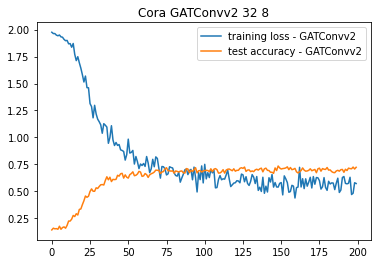

Node task. test set size: 140
heads
8

Maximum accuracy: 0.738
Minimum loss: 0.4035490155220032
0.7559999823570251


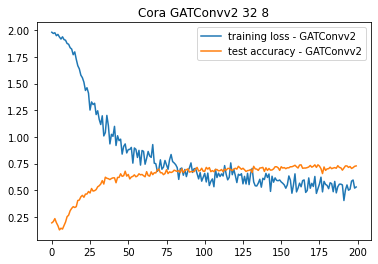

Node task. test set size: 140
heads
8

Maximum accuracy: 0.742
Minimum loss: 0.4739299714565277
0.7129999995231628


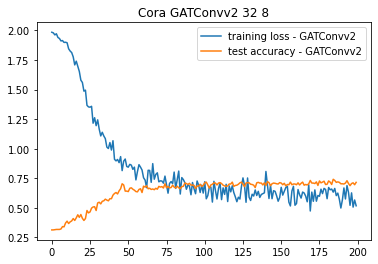

Node task. test set size: 140
heads
8

Maximum accuracy: 0.728
Minimum loss: 0.43370580673217773
0.7310000061988831


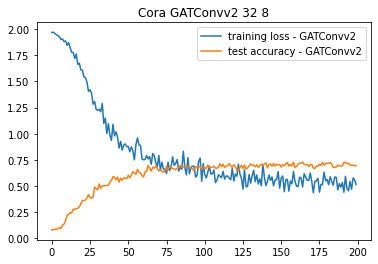

Node task. test set size: 140
heads
8

Maximum accuracy: 0.716
Minimum loss: 0.4511141777038574
0.7350000143051147


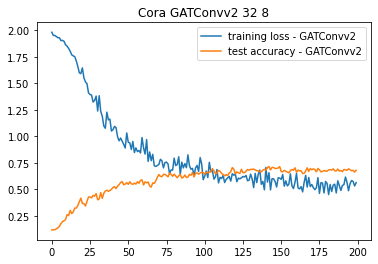

In [52]:
acc_GATv2=[]
best_GATv2=0
for count in range(5):
  args={'model_type': 'GATConvv2', 'dataset': 'Cora', 'num_layers': 2, 'heads': 8, 
         'batch_size': 32, 'hidden_dim': 8, 'dropout': 0.6, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
  if args["dataset"] == 'Cora':
    dataset=Planetoid(root=".", name="Cora")
  else: 
    dataset=Planetoid(root=".", name="Citeseer")
  test_accs, losses, model = train(dataset, args) 
  print("Maximum accuracy: {0}".format(max(test_accs)))
  print("Minimum loss: {0}".format(min(losses)))
  plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
  plt.plot(losses, label="training loss" + " - " + args["model_type"])
  plt.plot(test_accs, label="test accuracy" + " - " + args["model_type"])
  test_acc=testacc(model,dataset)
  if test_acc>best_GATv2:
    acc_GATv2=test_accs
    best_GATv2=test_acc
  print(test_acc)
  #generateGraph(model)
  #dimension_reduction(model)
  plt.legend()
  plt.show()

###citeseer

Node task. test set size: 120
heads
8

Maximum accuracy: 0.672
Minimum loss: 0.4067901372909546
0.6110000014305115


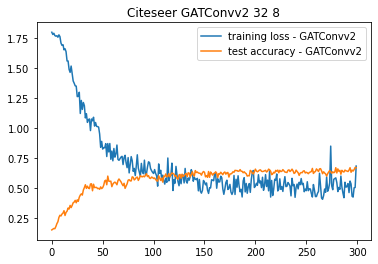

Node task. test set size: 120
heads
8

Maximum accuracy: 0.69
Minimum loss: 0.3382851481437683
0.6299999952316284


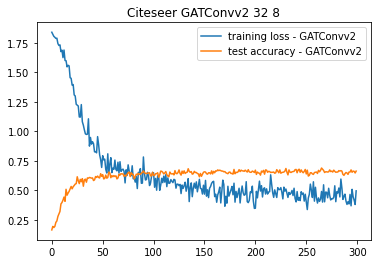

Node task. test set size: 120
heads
8

Maximum accuracy: 0.664
Minimum loss: 0.3503853380680084
0.625


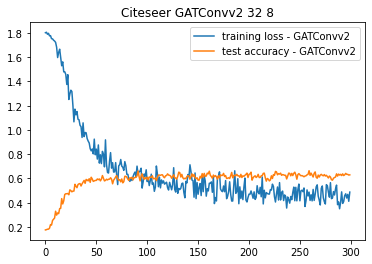

Node task. test set size: 120
heads
8

Maximum accuracy: 0.608
Minimum loss: 0.3660920262336731
0.5740000009536743


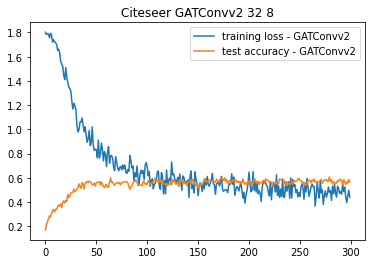

Node task. test set size: 120
heads
8

Maximum accuracy: 0.632
Minimum loss: 0.3774310350418091
0.640999972820282


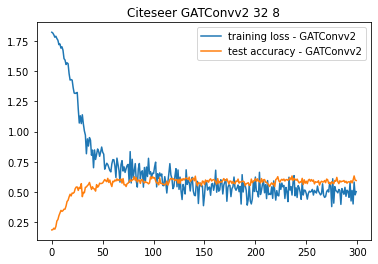

In [53]:
acc_GATv2_Citeseer=[]
best_GATv2_Citeseer=0
for count in range(5):
  args={'model_type': 'GATConvv2', 'dataset': 'Citeseer', 'num_layers': 2, 'heads': 8, 
         'batch_size': 32, 'hidden_dim': 8, 'dropout': 0.6, 'epochs': 300, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
  if args["dataset"] == 'Cora':
    dataset=Planetoid(root=".", name="Cora")
  else: 
    dataset=Planetoid(root=".", name="Citeseer",split='random')
  test_accs, losses, model = train(dataset, args) 
  print("Maximum accuracy: {0}".format(max(test_accs)))
  print("Minimum loss: {0}".format(min(losses)))
  plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
  plt.plot(losses, label="training loss" + " - " + args["model_type"])
  plt.plot(test_accs, label="test accuracy" + " - " + args["model_type"])
  test_acc=testacc(model,dataset)
  if test_acc>best_GATv2_Citeseer:
    acc_GATv2_Citeseer=test_accs
    best_GATv2_Citeseer=test_acc
  print(test_acc)
  #generateGraph(model)
  #dimension_reduction(model)
  plt.legend()
  plt.show()

In [54]:
print(best_GCNnorm)
print(best_GCNsum)
print(best_GAT)
print(best_GATv2)

0.7590000033378601
0.7440000176429749
0.7419999837875366
0.7559999823570251


In [37]:
print(best_GCNnorm_Citeseer)
print(best_GCNsum_Citeseer)

0.6620000004768372
0.6309999823570251


In [55]:
print(best_GCNnorm_Citeseer)
print(best_GCNsum_Citeseer)
print(best_GAT_Citeseer)
print(best_GATv2_Citeseer)

0.6620000004768372
0.6309999823570251
0.6840000152587891
0.640999972820282


##plot

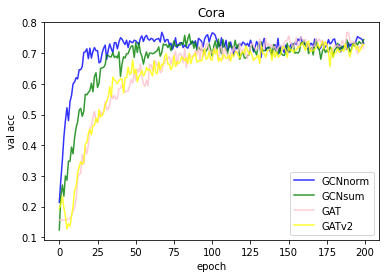

In [56]:
plt.title("Cora")
plt.plot(acc_GCNnorm, color='blue',alpha=0.8, label="GCNnorm")
plt.plot(acc_GCNsum,color='green',alpha=0.8, label="GCNsum")
plt.plot(acc_GAT, color='pink',alpha=0.8,label="GAT")
plt.plot(acc_GATv2, color='yellow',alpha=0.8,label="GATv2")
plt.ylabel('val acc')
plt.xlabel('epoch')
plt.legend()
plt.show()

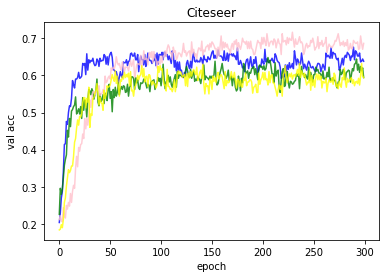

In [57]:
plt.title("Citeseer")
plt.plot(acc_GCNnorm_Citeseer, color='blue',alpha=0.8,label="GCN norm")
plt.plot(acc_GCNsum_Citeseer, color='green',alpha=0.8,label="GCNsum")
plt.plot(acc_GAT_Citeseer, color='pink',alpha=0.8,label="GAT")
plt.plot(acc_GATv2_Citeseer, color='yellow',alpha=0.8,label="GATv2")
plt.ylabel('val acc')
plt.xlabel('epoch')
plt.show()

##Does GAT help with over smoothing?

Node task. test set size: 140
heads
1


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Maximum accuracy: 0.754
0.7519999742507935
Node task. test set size: 140
heads
1

Maximum accuracy: 0.764
0.7139999866485596
Node task. test set size: 140
heads
1

Maximum accuracy: 0.746
0.7390000224113464
Node task. test set size: 140
heads
1

Maximum accuracy: 0.714
0.6620000004768372
Node task. test set size: 140
heads
1

Maximum accuracy: 0.542
0.4429999887943268
Node task. test set size: 140
heads
1

Maximum accuracy: 0.344
0.25699999928474426


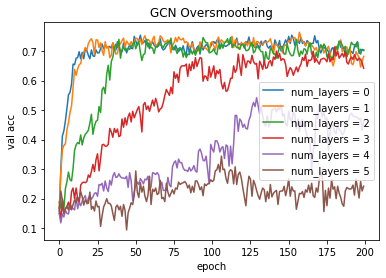

Node task. test set size: 140
heads
8

Maximum accuracy: 0.744
0.7570000290870667
Node task. test set size: 140
heads
8

Maximum accuracy: 0.742
0.7390000224113464
Node task. test set size: 140
heads
8

Maximum accuracy: 0.674
0.6669999957084656
Node task. test set size: 140
heads
8

Maximum accuracy: 0.58
0.5320000052452087
Node task. test set size: 140
heads
8

Maximum accuracy: 0.358
0.3409999907016754


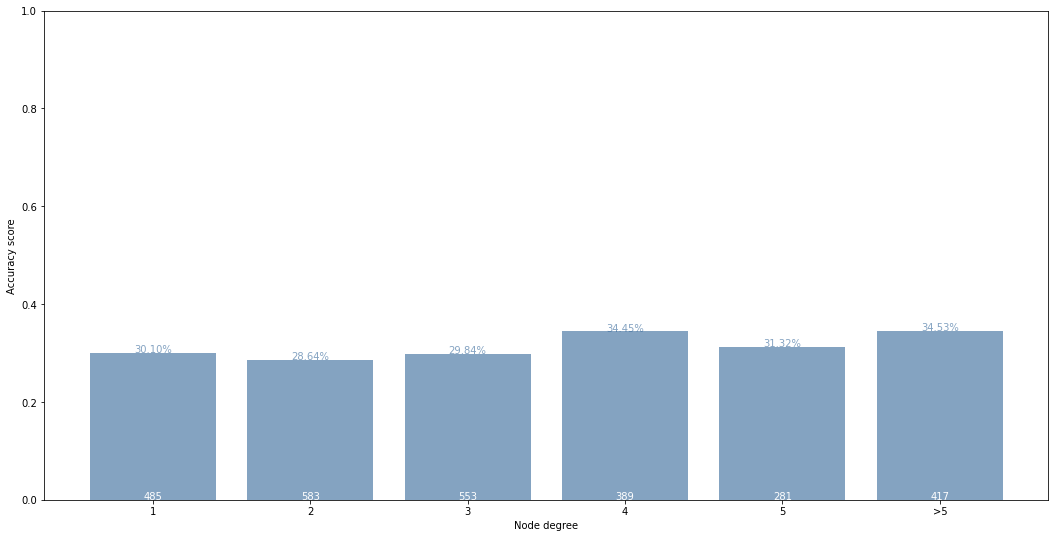

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


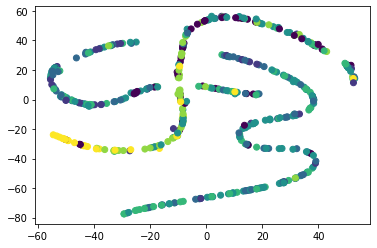

Node task. test set size: 140
heads
8


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Maximum accuracy: 0.144
0.10300000011920929


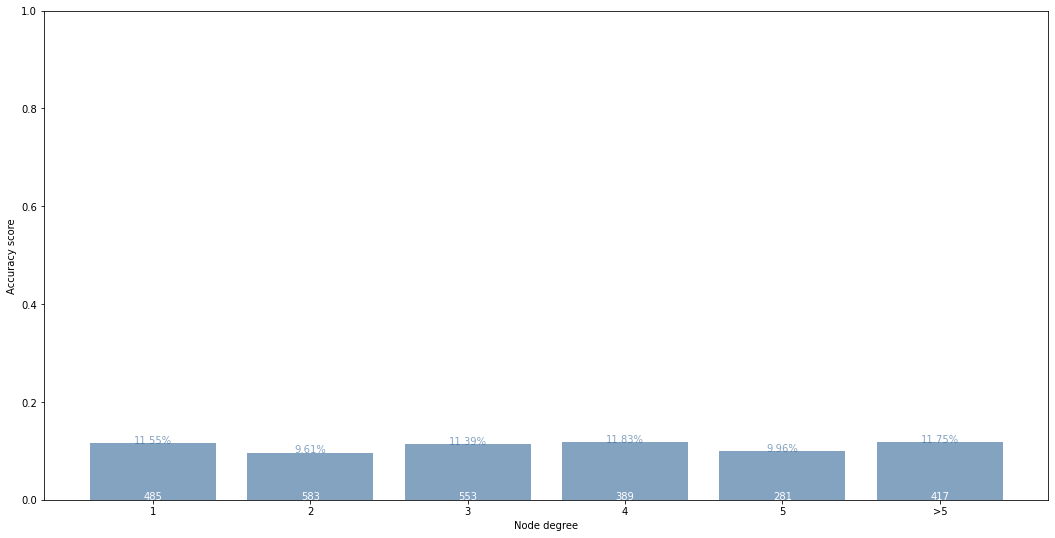

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


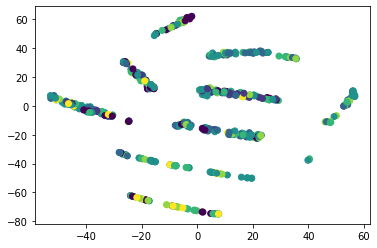

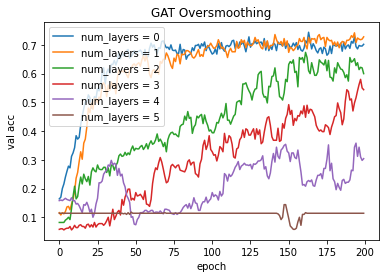

In [74]:
gcn_list=[]
args={'model_type': 'GCN', 'dataset': 'Cora', 'num_layers': 2, 'heads': 1, 
         'batch_size': 64, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
for num_layers in [1,2,3,4,5,6]:
    args["num_layers"]=num_layers
    if args["dataset"] == 'Cora':
        dataset=Planetoid(root=".", name="Cora")
    else: 
        dataset=Planetoid(root=".", name="Citeseer")
    test_accs, losses, model_conv = train(dataset, args) 
    print("Maximum accuracy: {0}".format(max(test_accs)))
    test_acc=testacc(model_conv,dataset)
    print(test_acc)
    #print("Minimum loss: {0}".format(min(losses)))
    #plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
    #plt.plot(losses, label="training loss" + " - " + args["model_type"])
    #plt.plot(test_accs, label="num_layers" + " = " + str(args["num_layers"]))
    gcn_list.append(test_accs)
    #generateGraph(model_conv)
    #dimension_reduction(model_conv)
for i in range(6):
  plt.plot(gcn_list[i], label="num_layers" + " = " + str(i))
plt.legend()
plt.title("GCN Oversmoothing")
plt.ylabel('val acc')
plt.xlabel('epoch')
plt.show()
gat_list=[]
args={'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 2, 'heads': 8, 
         'batch_size': 64, 'hidden_dim': 8, 'dropout': 0.6, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
for num_layers in [1,2,3,4,5,6]:
    args["num_layers"]=num_layers
    if args["dataset"] == 'Cora':
        dataset=Planetoid(root=".", name="Cora")
    else: 
        dataset=Planetoid(root=".", name="Citeseer")
    test_accs, losses, model_conv = train(dataset, args) 
    print("Maximum accuracy: {0}".format(max(test_accs)))
    test_acc=testacc(model_conv,dataset)
    print(test_acc)
    gat_list.append(test_accs)
    if num_layers==5 or num_layers==6:
        generateGraph(model_conv)
        dimension_reduction(model_conv)
for i in range(6):
  plt.plot(gat_list[i], label="num_layers" + " = " + str(i))
plt.legend()
plt.title("GAT Oversmoothing")
plt.ylabel('val acc')
plt.xlabel('epoch')
plt.show()

    


Node task. test set size: 140
heads
8


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)



Maximum accuracy: 0.734
0.7319999933242798
Node task. test set size: 140
heads
8

Maximum accuracy: 0.754
0.7369999885559082
Node task. test set size: 140
heads
8

Maximum accuracy: 0.69
0.6899999976158142
Node task. test set size: 140
heads
8

Maximum accuracy: 0.318
0.09099999815225601
Node task. test set size: 140
heads
8

Maximum accuracy: 0.206
0.09099999815225601


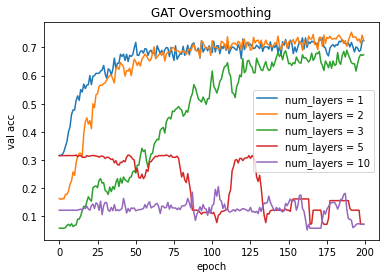

In [76]:
gat_accs=[]
num=[1,2,3,5,10]
args={'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 2, 'heads': 8, 
         'batch_size': 64, 'hidden_dim': 8, 'dropout': 0.6, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
for num_layers in [1,2,3,5,10]:
    args["num_layers"]=num_layers
    if args["dataset"] == 'Cora':
        dataset=Planetoid(root=".", name="Cora")
    else: 
        dataset=Planetoid(root=".", name="Citeseer")
    test_accs, losses, model_conv = train(dataset, args) 
    print("Maximum accuracy: {0}".format(max(test_accs)))
    test_acc=testacc(model_conv,dataset)
    print(test_acc)
    #print("Minimum loss: {0}".format(min(losses)))
    #plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
    #plt.plot(losses, label="training loss" + " - " + args["model_type"])
    #plt.plot(test_accs, label="num_layers" + " = " + args["num_layers"])
    gat_accs.append(test_accs)
    #generateGraph(model_conv)
    #dimension_reduction(model_conv)
for i in range(5):
  plt.plot(gat_accs[i], label="num_layers" + " = " + str(num[i]))
plt.legend()
plt.title("GAT Oversmoothing")
plt.ylabel('val acc')
plt.xlabel('epoch')
plt.show()


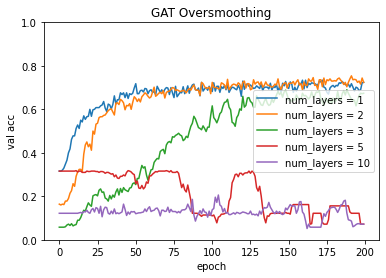

In [78]:
for i in range(5):
  plt.plot(gat_accs[i], label="num_layers" + " = " + str(num[i]))
plt.legend()
plt.title("GAT Oversmoothing")
plt.ylabel('val acc')
plt.xlabel('epoch')
plt.ylim(0,1)
plt.show()

##Compared with GCN oversmoothing

Node task. test set size: 140
heads
1
Epoch  0 Loss:  1.9526323080062866 Train Acc:  0.12857142857142856 Test Acc.:  0.204
Epoch  10 Loss:  0.72569739818573 Train Acc:  0.8 Test Acc.:  0.602
Epoch  20 Loss:  0.20020027458667755 Train Acc:  0.9357142857142857 Test Acc.:  0.674
Epoch  30 Loss:  0.1411105841398239 Train Acc:  0.9428571428571428 Test Acc.:  0.718
Epoch  40 Loss:  0.09157470613718033 Train Acc:  0.9642857142857143 Test Acc.:  0.714
Epoch  50 Loss:  0.04169066622853279 Train Acc:  0.9928571428571429 Test Acc.:  0.696
Epoch  60 Loss:  0.06935306638479233 Train Acc:  0.9857142857142858 Test Acc.:  0.706
Epoch  70 Loss:  0.03973085433244705 Train Acc:  1.0 Test Acc.:  0.682
Epoch  80 Loss:  0.08945061266422272 Train Acc:  0.9571428571428572 Test Acc.:  0.704
Epoch  90 Loss:  0.06990942358970642 Train Acc:  0.9785714285714285 Test Acc.:  0.71
Epoch  100 Loss:  0.11858764290809631 Train Acc:  0.9928571428571429 Test Acc.:  0.708
Epoch  110 Loss:  0.09025108814239502 Train Acc:  0


Maximum accuracy: 0.732


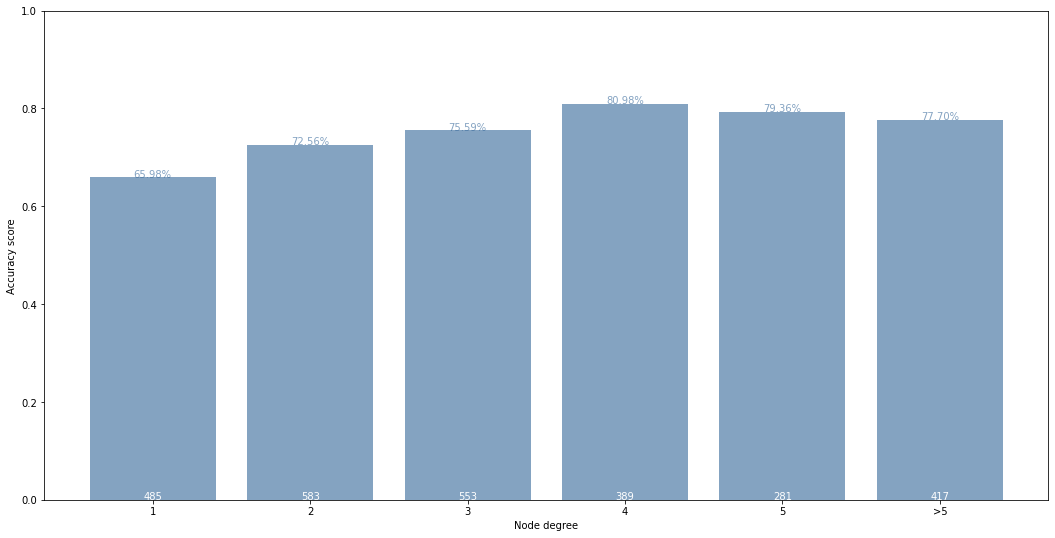

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


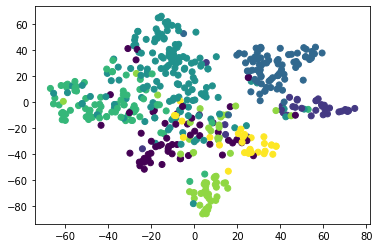

Node task. test set size: 140
heads
1
Epoch  0 Loss:  1.9626240730285645 Train Acc:  0.1 Test Acc.:  0.252


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch  10 Loss:  0.9906644821166992 Train Acc:  0.6928571428571428 Test Acc.:  0.614
Epoch  20 Loss:  0.38287264108657837 Train Acc:  0.8785714285714286 Test Acc.:  0.692
Epoch  30 Loss:  0.34103602170944214 Train Acc:  0.9214285714285714 Test Acc.:  0.69
Epoch  40 Loss:  0.1449369192123413 Train Acc:  0.9642857142857143 Test Acc.:  0.734
Epoch  50 Loss:  0.11062748730182648 Train Acc:  0.9642857142857143 Test Acc.:  0.71
Epoch  60 Loss:  0.08775673061609268 Train Acc:  0.9785714285714285 Test Acc.:  0.718
Epoch  70 Loss:  0.07904823869466782 Train Acc:  0.9714285714285714 Test Acc.:  0.724
Epoch  80 Loss:  0.027790138497948647 Train Acc:  0.9928571428571429 Test Acc.:  0.706
Epoch  90 Loss:  0.05610742047429085 Train Acc:  0.9928571428571429 Test Acc.:  0.75
Epoch  100 Loss:  0.0768216922879219 Train Acc:  0.9714285714285714 Test Acc.:  0.704
Epoch  110 Loss:  0.056034497916698456 Train Acc:  0.9857142857142858 Test Acc.:  0.732
Epoch  120 Loss:  0.09223266690969467 Train Acc:  0.9857


Maximum accuracy: 0.75


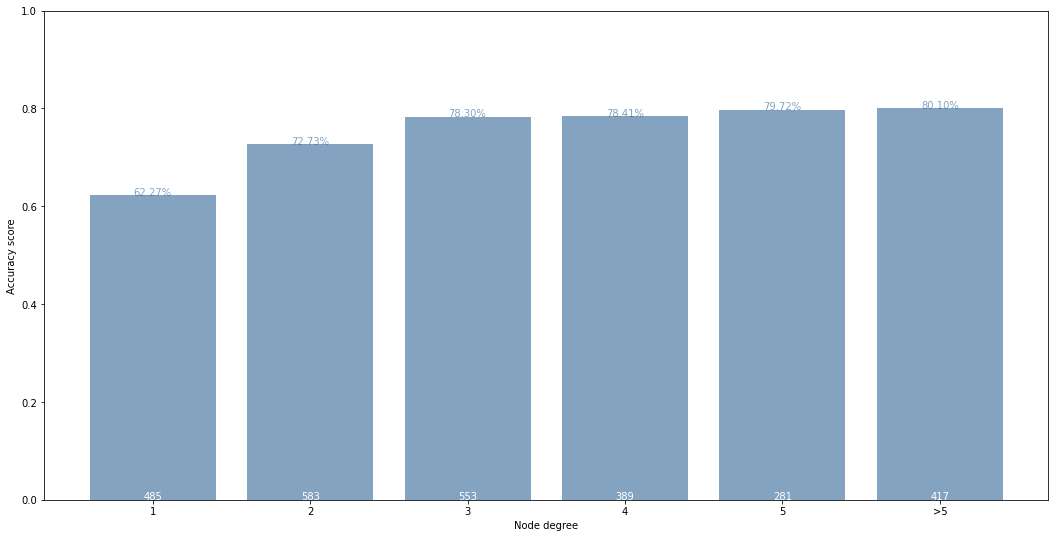

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


KeyboardInterrupt: ignored

In [ ]:
def main():
  args={'model_type': 'GCN', 'dataset': 'Cora', 'num_layers': 2, 'heads': 1, 
         'batch_size': 64, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
  for num_layers in [1,2,3,4,5,6]:
      args["num_layers"]=num_layers
      if args["dataset"] == 'Cora':
        dataset=Planetoid(root=".", name="Cora")
      else: 
        dataset=Planetoid(root=".", name="Citeseer")
      test_accs, losses, model_conv = train(dataset, args) 
      print("Maximum accuracy: {0}".format(max(test_accs)))
      #print("Minimum loss: {0}".format(min(losses)))
      #plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
      #plt.plot(losses, label="training loss" + " - " + args["model_type"])
      #plt.plot(test_accs, label="test accuracy" + " - " + args["model_type"])
      generateGraph(model_conv)
      dimension_reduction(model_conv)
      #plt.legend()
      #plt.show()
    
if __name__ == '__main__':
    main()

##Explore components
Maybe heads, postmp, num layers.

Node task. test set size: 140
Epoch  0 Loss:  1.942596673965454 Test Acc.:  0.25


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch  10 Loss:  0.9316368103027344 Test Acc.:  0.616
Epoch  20 Loss:  0.37126708030700684 Test Acc.:  0.688
Epoch  30 Loss:  0.1173197478055954 Test Acc.:  0.724
Epoch  40 Loss:  0.10997062921524048 Test Acc.:  0.716
Epoch  50 Loss:  0.1238805502653122 Test Acc.:  0.746
Epoch  60 Loss:  0.07695212960243225 Test Acc.:  0.742
Epoch  70 Loss:  0.057795360684394836 Test Acc.:  0.73
Epoch  80 Loss:  0.03171604499220848 Test Acc.:  0.744
Epoch  90 Loss:  0.06516005098819733 Test Acc.:  0.738
Epoch  100 Loss:  0.13876722753047943 Test Acc.:  0.726
Epoch  110 Loss:  0.048202041536569595 Test Acc.:  0.712
Epoch  120 Loss:  0.07241711020469666 Test Acc.:  0.714
Epoch  130 Loss:  0.03122328408062458 Test Acc.:  0.734
Epoch  140 Loss:  0.03394661471247673 Test Acc.:  0.716
Epoch  150 Loss:  0.04586290195584297 Test Acc.:  0.722
Epoch  160 Loss:  0.029190141707658768 Test Acc.:  0.724
Epoch  170 Loss:  0.0554872527718544 Test Acc.:  0.732
Epoch  180 Loss:  0.060602691024541855 Test Acc.:  0.706
Ep

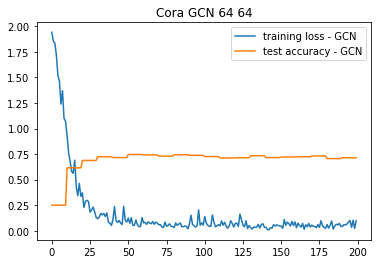

In [ ]:
args={'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 1, 'heads': 2, 
         'batch_size': 64, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
if args["dataset"] == 'Cora':
  dataset=Planetoid(root=".", name="Cora")
else: 
  dataset=Planetoid(root=".", name="Citeseer")
test_accs, losses, model_GCN = train(dataset, args) 
print("Maximum accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))
plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
plt.plot(losses, label="training loss" + " - " + args["model_type"])
plt.plot(test_accs, label="test accuracy" + " - " + args["model_type"])
plt.legend()
plt.show()

##PPI dataset

In [79]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader

from sklearn import metrics

#path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
train_dataset = PPI(root=".", split='train')
val_dataset = PPI(root=".",  split='val')
test_dataset = PPI(root=".", split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

    
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCN(train_dataset.num_features, 1024)
        self.lin1 = torch.nn.Linear(train_dataset.num_features,  1024)
        self.conv2 = GCN(1024, 1024)
        self.lin2 = torch.nn.Linear(1024, 1024)
        self.conv3 = GCN( 1024, train_dataset.num_classes)
        self.lin3 = torch.nn.Linear(1024, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    total_micro_f1 = 0
    for data in loader:
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        pred = (out > 0).float().cpu()
        micro_f1 = metrics.f1_score(data.y, pred, average='micro')
        total_micro_f1 += micro_f1 * data.num_graphs
    return total_micro_f1 / len(loader.dataset)


for epoch in range(1, 101):
    loss = train()
    acc = test(val_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Acc: {:.4f}'.format(epoch, loss, acc))
acc=(test(test_loader))
print(acc)

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 01, Loss: 45.4810, Acc: 0.4251
Epoch: 02, Loss: 7.4671, Acc: 0.4613
Epoch: 03, Loss: 3.3464, Acc: 0.4836
Epoch: 04, Loss: 1.9021, Acc: 0.5050
Epoch: 05, Loss: 1.2084, Acc: 0.4927
Epoch: 06, Loss: 0.8594, Acc: 0.4907
Epoch: 07, Loss: 0.8160, Acc: 0.5026
Epoch: 08, Loss: 0.7216, Acc: 0.4975
Epoch: 09, Loss: 0.6284, Acc: 0.5169
Epoch: 10, Loss: 0.6127, Acc: 0.5055
Epoch: 11, Loss: 0.6438, Acc: 0.5160
Epoch: 12, Loss: 0.6267, Acc: 0.4974
Epoch: 13, Loss: 0.6450, Acc: 0.4988
Epoch: 14, Loss: 0.6446, Acc: 0.4993
Epoch: 15, Loss: 0.6460, Acc: 0.4951
Epoch: 16, Loss: 0.6998, Acc: 0.4791
Epoch: 17, Loss: 0.7125, Acc: 0.5467
Epoch: 18, Loss: 0.6955, Acc: 0.5091
Epoch: 19, Loss: 0.6998, Acc: 0.5040
Epoch: 20, Loss: 0.7179, Acc: 0.5663
Epoch: 21, Loss: 0.6517, Acc: 0.5395
Epoch: 22, Loss: 0.6555, Acc: 0.5598
Epoch: 23, Loss: 0.6475, Acc: 0.5443
Epoch: 24, Loss: 0.6303, Acc: 0.5196
Epoch: 25, Loss: 0.6642, Acc: 0.4813
Epoch: 26, Loss: 0.7522, Acc: 0.5643
Epoch: 27, Loss: 0.7116, Acc: 0.5353


In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader

from sklearn import metrics

#path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
train_dataset = PPI(root=".", split='train')
val_dataset = PPI(root=".",  split='test')
test_dataset = PPI(root=".", split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GATConv(train_dataset.num_features, 256, heads=4)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * 256)
        self.conv2 = GATConv(4 * 256, 256, heads=4)
        self.lin2 = torch.nn.Linear(4 * 256, 4 * 256)
        self.conv3 = GATConv(
            4 * 256, train_dataset.num_classes, heads=6, concat=False)
        self.lin3 = torch.nn.Linear(4 * 256, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    total_micro_f1 = 0
    for data in loader:
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        pred = (out > 0).float().cpu()
        micro_f1 = metrics.f1_score(data.y, pred, average='micro')
        total_micro_f1 += micro_f1 * data.num_graphs
    return total_micro_f1 / len(loader.dataset)


for epoch in range(1, 101):
    loss = train()
    acc = test(val_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Acc: {:.4f}'.format(epoch, loss, acc))
acc=(test(test_loader))
print(acc)

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 01, Loss: 0.8146, Acc: 0.4826
Epoch: 02, Loss: 0.5503, Acc: 0.5516
Epoch: 03, Loss: 0.5337, Acc: 0.5378
Epoch: 04, Loss: 0.5076, Acc: 0.5767
Epoch: 05, Loss: 0.4945, Acc: 0.5889
Epoch: 06, Loss: 0.4764, Acc: 0.6303
Epoch: 07, Loss: 0.4565, Acc: 0.6399
Epoch: 08, Loss: 0.4426, Acc: 0.6615
Epoch: 09, Loss: 0.4284, Acc: 0.6885
Epoch: 10, Loss: 0.4154, Acc: 0.7126
Epoch: 11, Loss: 0.3988, Acc: 0.7032
Epoch: 12, Loss: 0.3941, Acc: 0.7322
Epoch: 13, Loss: 0.3712, Acc: 0.7351
Epoch: 14, Loss: 0.3586, Acc: 0.7459
Epoch: 15, Loss: 0.3494, Acc: 0.7692
Epoch: 16, Loss: 0.3360, Acc: 0.7820
Epoch: 17, Loss: 0.3384, Acc: 0.7962
Epoch: 18, Loss: 0.3158, Acc: 0.8137
Epoch: 19, Loss: 0.3067, Acc: 0.8142
Epoch: 20, Loss: 0.2949, Acc: 0.8276
Epoch: 21, Loss: 0.2921, Acc: 0.8340
Epoch: 22, Loss: 0.2863, Acc: 0.8496
Epoch: 23, Loss: 0.2720, Acc: 0.8361
Epoch: 24, Loss: 0.2757, Acc: 0.8544
Epoch: 25, Loss: 0.2649, Acc: 0.8661
Epoch: 26, Loss: 0.2579, Acc: 0.8672
Epoch: 27, Loss: 0.2551, Acc: 0.8709
E

In [60]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader

from sklearn import metrics

#path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
train_dataset = PPI(root=".", split='train')
val_dataset = PPI(root=".",  split='val')
test_dataset = PPI(root=".", split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
print(train_dataset.num_features)
for data in train_loader:
  print((data.edge_index).size())
  print(U.to_dense_adj(data.edge_index).squeeze(0).size())
  break
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCN_sum(train_dataset.num_features, 1024)
        self.lin1 = torch.nn.Linear(train_dataset.num_features,  1024)
        self.conv2 = GCN_sum(1024, 1024)
        self.lin2 = torch.nn.Linear(1024, 1024)
        self.conv3 = GCN_sum(1024, train_dataset.num_classes)
        self.lin3 = torch.nn.Linear(1024, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index)+self.lin1(x))
        x = F.elu(self.conv2(x, edge_index)+self.lin2(x))
        x = self.conv3(x, edge_index)+self.lin3(x)
        return x
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        #print(data.size())
        #print(data.edge_index.size())
        #print(data.x.size())
      #  print(adj.size())
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    total_micro_f1 = 0
    for data in loader:
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        pred = (out > 0).float().cpu()
        micro_f1 = metrics.f1_score(data.y, pred, average='micro')
        total_micro_f1 += micro_f1 * data.num_graphs
    return total_micro_f1 / len(loader.dataset)


for epoch in range(1, 101):
    loss = train()
    acc = test(val_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Acc: {:.4f}'.format(epoch, loss, acc))
acc=(test(test_loader))
print(acc)

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


50
torch.Size([2, 65430])
torch.Size([2339, 2339])
Epoch: 01, Loss: 1202.6566, Acc: 0.3181
Epoch: 02, Loss: 27.0085, Acc: 0.4613
Epoch: 03, Loss: 8.6799, Acc: 0.4795
Epoch: 04, Loss: 2.9307, Acc: 0.4140
Epoch: 05, Loss: 1.4209, Acc: 0.4414
Epoch: 06, Loss: 1.1621, Acc: 0.4470
Epoch: 07, Loss: 1.2819, Acc: 0.4709
Epoch: 08, Loss: 1.3431, Acc: 0.4321
Epoch: 09, Loss: 1.2413, Acc: 0.4518
Epoch: 10, Loss: 1.4228, Acc: 0.4496
Epoch: 11, Loss: 1.5696, Acc: 0.4561
Epoch: 12, Loss: 1.5821, Acc: 0.4215
Epoch: 13, Loss: 1.6442, Acc: 0.4685
Epoch: 14, Loss: 1.6990, Acc: 0.4451
Epoch: 15, Loss: 1.7697, Acc: 0.4341
Epoch: 16, Loss: 1.7414, Acc: 0.4586
Epoch: 17, Loss: 1.8720, Acc: 0.4690
Epoch: 18, Loss: 1.7451, Acc: 0.4255
Epoch: 19, Loss: 1.9228, Acc: 0.4619
Epoch: 20, Loss: 1.8935, Acc: 0.4016
Epoch: 21, Loss: 2.1307, Acc: 0.4293
Epoch: 22, Loss: 2.0098, Acc: 0.4267
Epoch: 23, Loss: 2.0688, Acc: 0.4581
Epoch: 24, Loss: 2.1486, Acc: 0.4589
Epoch: 25, Loss: 2.2951, Acc: 0.4596
Epoch: 26, Loss: 2.2

ValueError: ignored

In [61]:
print(acc)

0.48909128387785533


In [103]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import PPI
from torch_geometric.data import DataLoader

from sklearn import metrics

#path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
train_dataset = PPI(root=".", split='train')
val_dataset = PPI(root=".",  split='test')
test_dataset = PPI(root=".", split='test')
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GATConvv2(train_dataset.num_features, 256, heads=4)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 4 * 256)
        self.conv2 = GATConvv2(4 * 256, 256, heads=4)
        self.lin2 = torch.nn.Linear(4 * 256, 4 * 256)
        self.conv3 = GATConvv2(
            4 * 256, train_dataset.num_classes, heads=6, concat=False)
        self.lin3 = torch.nn.Linear(4 * 256, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)
        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
loss_op = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = None
        data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    total_micro_f1 = 0
    for data in loader:
        with torch.no_grad():
            out = model(data.x.to(device), data.edge_index.to(device))
        pred = (out > 0).float().cpu()
        micro_f1 = metrics.f1_score(data.y, pred, average='micro')
        total_micro_f1 += micro_f1 * data.num_graphs
    return total_micro_f1 / len(loader.dataset)


for epoch in range(1, 101):
    loss = train()
    acc = test(val_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Acc: {:.4f}'.format(epoch, loss, acc))

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch: 01, Loss: 0.9927, Acc: 0.4494
Epoch: 02, Loss: 0.5351, Acc: 0.4824
Epoch: 03, Loss: 0.4874, Acc: 0.5971
Epoch: 04, Loss: 0.4461, Acc: 0.6493
Epoch: 05, Loss: 0.4070, Acc: 0.6525
Epoch: 06, Loss: 0.3646, Acc: 0.7281
Epoch: 07, Loss: 0.3093, Acc: 0.7498
Epoch: 08, Loss: 0.2742, Acc: 0.8125
Epoch: 09, Loss: 0.2276, Acc: 0.8464
Epoch: 10, Loss: 0.1941, Acc: 0.8839
Epoch: 11, Loss: 0.1507, Acc: 0.9101
Epoch: 12, Loss: 0.1275, Acc: 0.9214
Epoch: 13, Loss: 0.1064, Acc: 0.9427
Epoch: 14, Loss: 0.0892, Acc: 0.9402
Epoch: 15, Loss: 0.0769, Acc: 0.9548
Epoch: 16, Loss: 0.0616, Acc: 0.9609
Epoch: 17, Loss: 0.0503, Acc: 0.9673
Epoch: 18, Loss: 0.0448, Acc: 0.9699
Epoch: 19, Loss: 0.0367, Acc: 0.9736
Epoch: 20, Loss: 0.0322, Acc: 0.9759
Epoch: 21, Loss: 0.0296, Acc: 0.9762
Epoch: 22, Loss: 0.0258, Acc: 0.9786
Epoch: 23, Loss: 0.0243, Acc: 0.9804
Epoch: 24, Loss: 0.0227, Acc: 0.9810
Epoch: 25, Loss: 0.0198, Acc: 0.9826
Epoch: 26, Loss: 0.0180, Acc: 0.9822
Epoch: 27, Loss: 0.0177, Acc: 0.9830
E

In [ ]:
import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import GNNBenchmarkDataset
from torch_geometric.data import DataLoader

from sklearn import metrics

import os.path as osp

import torch
import torch.nn.functional as F
from torch_geometric.datasets import GNNBenchmarkDataset
from torch_geometric.data import DataLoader

from sklearn import metrics

#path = osp.join(osp.dirname(osp.realpath(__file__)), 'data', 'PPI')
train_dataset = GNNBenchmarkDataset(root=".",name="PATTERN",split='train')
val_dataset = GNNBenchmarkDataset(root=".",name="PATTERN",split='val')
test_dataset = GNNBenchmarkDataset(root=".",name="PATTERN",split='test')
train_loader = DataLoader(train_dataset,batch_size=512,shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=512,shuffle=False)
test_loader = DataLoader(test_dataset,batch_size=512, shuffle=False)


class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GATConv(train_dataset.num_features, 64, heads=2)
        self.lin1 = torch.nn.Linear(train_dataset.num_features, 2 * 64)
        self.conv2 = GATConv(2 * 64, 64, heads=2)
        self.lin2 = torch.nn.Linear(2 * 64, 2 * 64)
        self.conv3 = GATConv(
            2 * 64, train_dataset.num_classes, heads=6, concat=False)
        self.lin3 = torch.nn.Linear(2 * 64, train_dataset.num_classes)

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index) + self.lin1(x))
        x = F.elu(self.conv2(x, edge_index) + self.lin2(x))
        x = self.conv3(x, edge_index) + self.lin3(x)

        return x


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
loss_op = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)


def train():
    model.train()

    total_loss = 0
    for data in train_loader:
        num_graphs = data.num_graphs
        data.batch = 512
        #data = data.to(device)
        optimizer.zero_grad()
        loss = loss_op(model(data.x, data.edge_index), data.y)
        total_loss += loss.item() * num_graphs
        loss.backward()
        optimizer.step()
    print(total_loss / len(train_loader.dataset))
    return total_loss / len(train_loader.dataset)


def test(loader):
    model.eval()

    total = 0
    for data in loader:
        with torch.no_grad():
            out = model(data.x, data.edge_index)
        pred=np.argmax(out,axis=1)
        micro_f1 = metrics.f1_score(data.y, pred, average='micro')
        total+= (pred == data.y).sum()
    return (total / len(loader.dataset)).item()
        #total_micro_f1 += micro_f1 * data.num_graphs
    #return total_micro_f1 / len(loader.dataset)


for epoch in range(1, 10):
    loss = train()
    acc = test(val_loader)
    print('Epoch: {:02d}, Loss: {:.4f}, Acc: {:.4f}'.format(epoch, loss, acc))
acc=test(train_loader)   
print(acc)

/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


0.5472059800624848
Epoch: 01, Loss: 0.5472, Acc: 97.5830
0.4704703800678253
Epoch: 02, Loss: 0.4705, Acc: 97.5830
0.4670912084102631
Epoch: 03, Loss: 0.4671, Acc: 97.5830
0.466352356338501
Epoch: 04, Loss: 0.4664, Acc: 97.5830
0.46625088424682615
Epoch: 05, Loss: 0.4663, Acc: 97.5830
0.4661555271625519
Epoch: 06, Loss: 0.4662, Acc: 97.5830
0.46607496242523194
Epoch: 07, Loss: 0.4661, Acc: 97.5830
0.46605597367286683
Epoch: 08, Loss: 0.4661, Acc: 97.5830
0.4660115756511688
Epoch: 09, Loss: 0.4660, Acc: 97.5830
97.9219970703125


##Plot accuracy for node degree

In [ ]:
def accuracy(pred_y,y):
  return ((pred_y == y).sum() / len(y)).item()

In [ ]:
from torch_geometric.utils import degree
def generateGraph(model):
  dataset = Planetoid(root='.', name="Cora")
  
  data=dataset[0]
  model.embedding=True
# Get model's classifications
  out = model(data)

# Calculate the degree of each node
  degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
  accuracies = []
  sizes = []

# Accuracy for degrees between 0 and 5
  for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))

# Accuracy for degrees > 5
  mask = np.where(degrees > 5)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Bar plot
  fig, ax = plt.subplots(figsize=(18, 9))
  plt.ylim(0, 1)
  ax.set_xlabel('Node degree')
  ax.set_ylabel('Accuracy score')
  plt.bar(['0','1','2','3','4','5','>5'],accuracies,color=(0.2, 0.4, 0.6, 0.6))
  for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%', ha='center', color=(0.2, 0.4, 0.6, 0.6))
  for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],ha='center', color='white')
  plt.show()

##Try a GAT

Node task. test set size: 140
heads
2
Epoch  0 Loss:  1.9529545307159424 Train Acc:  0.12857142857142856 Test Acc.:  0.126
Epoch  10 Loss:  1.849951148033142 Train Acc:  0.32142857142857145 Test Acc.:  0.51
Epoch  20 Loss:  1.1228371858596802 Train Acc:  0.6642857142857143 Test Acc.:  0.678
Epoch  30 Loss:  0.5623873472213745 Train Acc:  0.8357142857142857 Test Acc.:  0.734
Epoch  40 Loss:  0.40691468119621277 Train Acc:  0.8785714285714286 Test Acc.:  0.752
Epoch  50 Loss:  0.31667885184288025 Train Acc:  0.9071428571428571 Test Acc.:  0.74
Epoch  60 Loss:  0.25537458062171936 Train Acc:  0.9071428571428571 Test Acc.:  0.74
Epoch  70 Loss:  0.3177078366279602 Train Acc:  0.8714285714285714 Test Acc.:  0.76
Epoch  80 Loss:  0.1319458782672882 Train Acc:  0.9571428571428572 Test Acc.:  0.752
Epoch  90 Loss:  0.2533094882965088 Train Acc:  0.9 Test Acc.:  0.734
Epoch  100 Loss:  0.2919765114784241 Train Acc:  0.9071428571428571 Test Acc.:  0.766
Epoch  110 Loss:  0.25657325983047485 Trai

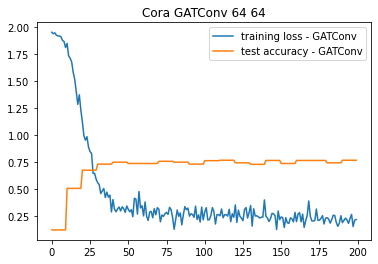

In [ ]:
args={'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 2, 'heads': 2, 
         'batch_size': 64, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
if args["dataset"] == 'Cora':
  dataset=Planetoid(root=".", name="Cora")
else: 
  dataset=Planetoid(root=".", name="Citeseer")
test_accs, losses, model_GATConv = train(dataset, args) 
print("Maximum accuracy: {0}".format(max(test_accs)))
print("Minimum loss: {0}".format(min(losses)))
plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
plt.plot(losses, label="training loss" + " - " + args["model_type"])
plt.plot(test_accs, label="test accuracy" + " - " + args["model_type"])
plt.legend()
plt.show()

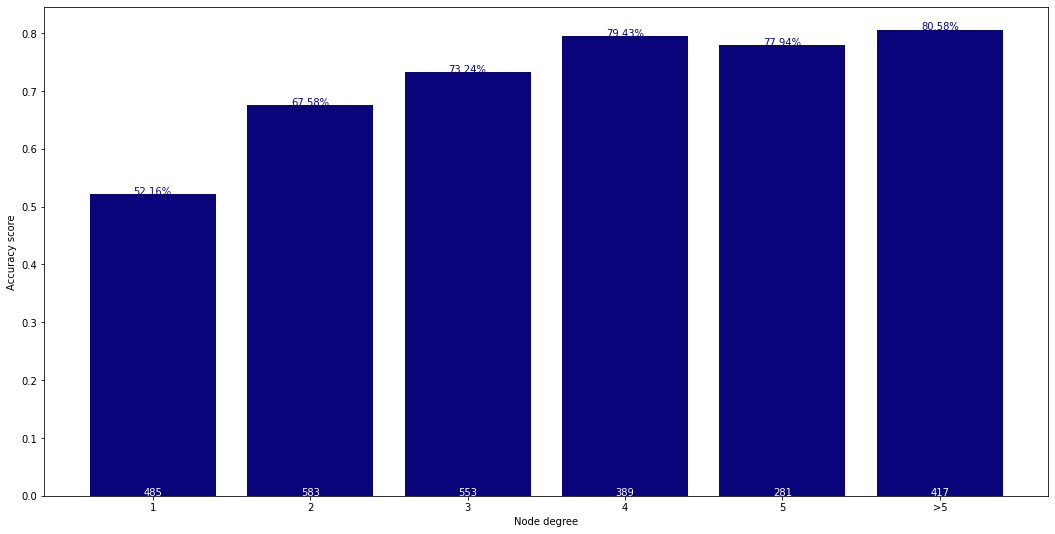

In [ ]:
generateGraph(model_GATConv)

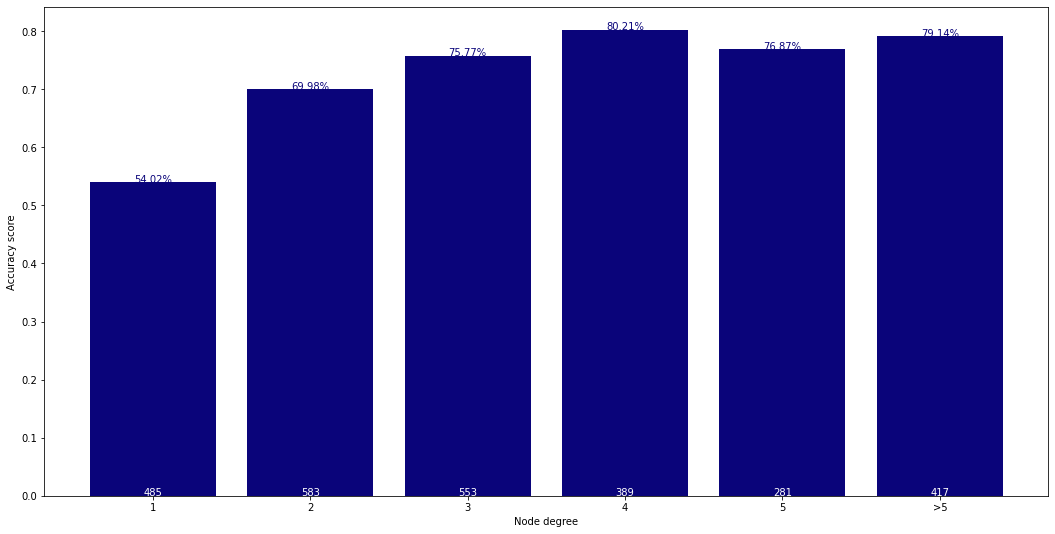

In [ ]:
generateGraph(model_GATConv)

##Show distribution

In [ ]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

In [ ]:
def plotEmbedding(model):
  dataset = Planetoid(root='.', name="Cora")
  data=dataset[0]
  h = model.emb(data)

# Train TSNE
  tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
  plt.figure(figsize=(10, 10))
  plt.axis('off')
  plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
  plt.show()



In [ ]:
def dimension_reduction(model: nn.Module):
  """
    Args:
      model: model object for generating features
    
    Return:
      pd.DataFrame: A data frame that has 'dimension 1', 'dimension 2', and 'labels' as a column
  """
    ## ------ Begin Solution ------ ##
  model.emb=True
  dataset = Planetoid(root='.', name="Cora")
  data=dataset[0]
  emb = (model.generate_emb(data)).detach().numpy()
  #emb=emb[data.val_mask]
  y=data.y[data.val_mask]
  t=TSNE(n_components=2).fit_transform(emb)[data["val_mask"]]
  data = {'dimension 1':t[:,0], 'dimension 2':t[:,1], 'labels':y}
  df = pd.DataFrame(data)
  plt.scatter(df['dimension 1'], df['dimension 2'], c=df['labels'])
  plt.show()

In [ ]:
def visualise(feature_dict: typing.Dict) -> None:
    ## ------ Begin Solution ------ ##
    df=feature_dict[layer]
    plt.scatter(df['dimension 1'], df['dimension 2'], c=df['labels'])
    plt.show()

##GAT help with oversmoothing?

Node task. test set size: 140
heads
2
Epoch  0 Loss:  1.9458205699920654 Train Acc:  0.17142857142857143 Test Acc.:  0.13
Epoch  10 Loss:  1.414994239807129 Train Acc:  0.7 Test Acc.:  0.64
Epoch  20 Loss:  0.6184821128845215 Train Acc:  0.8285714285714286 Test Acc.:  0.704
Epoch  30 Loss:  0.33176422119140625 Train Acc:  0.8857142857142857 Test Acc.:  0.736
Epoch  40 Loss:  0.2731855809688568 Train Acc:  0.9214285714285714 Test Acc.:  0.716
Epoch  50 Loss:  0.17604835331439972 Train Acc:  0.9714285714285714 Test Acc.:  0.732
Epoch  60 Loss:  0.1873110979795456 Train Acc:  0.9571428571428572 Test Acc.:  0.746
Epoch  70 Loss:  0.24302363395690918 Train Acc:  0.9285714285714286 Test Acc.:  0.73
Epoch  80 Loss:  0.22595763206481934 Train Acc:  0.95 Test Acc.:  0.736
Epoch  90 Loss:  0.16579076647758484 Train Acc:  0.9714285714285714 Test Acc.:  0.728
Epoch  100 Loss:  0.1696009635925293 Train Acc:  0.9571428571428572 Test Acc.:  0.762
Epoch  110 Loss:  0.24947242438793182 Train Acc:  0.92

Maximum accuracy: 0.762


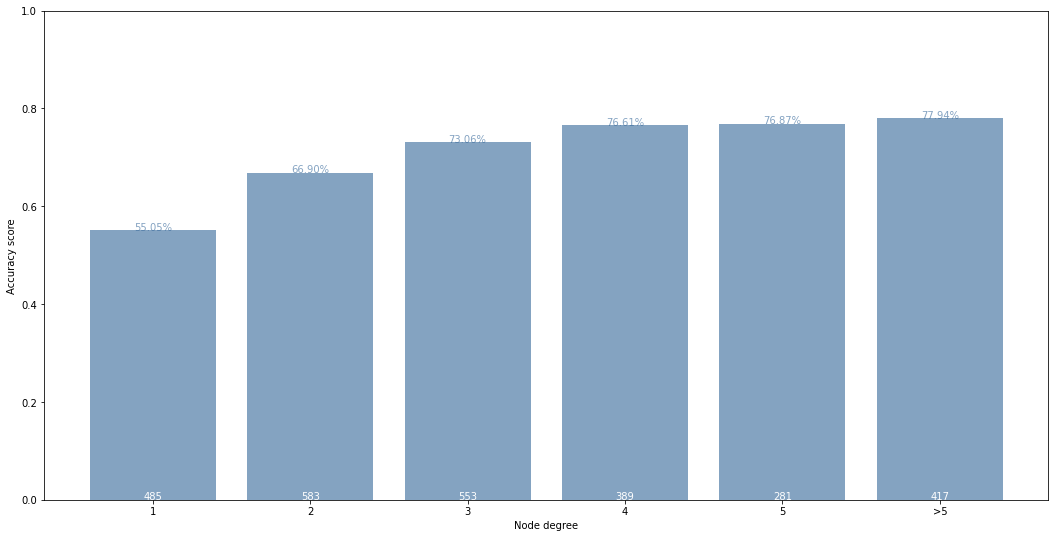

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


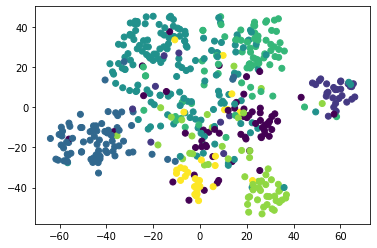

Node task. test set size: 140
heads
2
Epoch  0 Loss:  1.9454225301742554 Train Acc:  0.15714285714285714 Test Acc.:  0.114


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch  10 Loss:  1.7396281957626343 Train Acc:  0.4 Test Acc.:  0.47
Epoch  20 Loss:  0.969591498374939 Train Acc:  0.6785714285714286 Test Acc.:  0.598
Epoch  30 Loss:  0.6142730712890625 Train Acc:  0.7785714285714286 Test Acc.:  0.726
Epoch  40 Loss:  0.49523141980171204 Train Acc:  0.8357142857142857 Test Acc.:  0.768
Epoch  50 Loss:  0.34694063663482666 Train Acc:  0.8785714285714286 Test Acc.:  0.77
Epoch  60 Loss:  0.3549993634223938 Train Acc:  0.8714285714285714 Test Acc.:  0.742
Epoch  70 Loss:  0.26771149039268494 Train Acc:  0.9214285714285714 Test Acc.:  0.784
Epoch  80 Loss:  0.2624698579311371 Train Acc:  0.9285714285714286 Test Acc.:  0.76
Epoch  90 Loss:  0.22831815481185913 Train Acc:  0.9357142857142857 Test Acc.:  0.778
Epoch  100 Loss:  0.2720019519329071 Train Acc:  0.9285714285714286 Test Acc.:  0.758
Epoch  110 Loss:  0.18072305619716644 Train Acc:  0.9428571428571428 Test Acc.:  0.752
Epoch  120 Loss:  0.29226958751678467 Train Acc:  0.9 Test Acc.:  0.772
Epoch

Maximum accuracy: 0.784


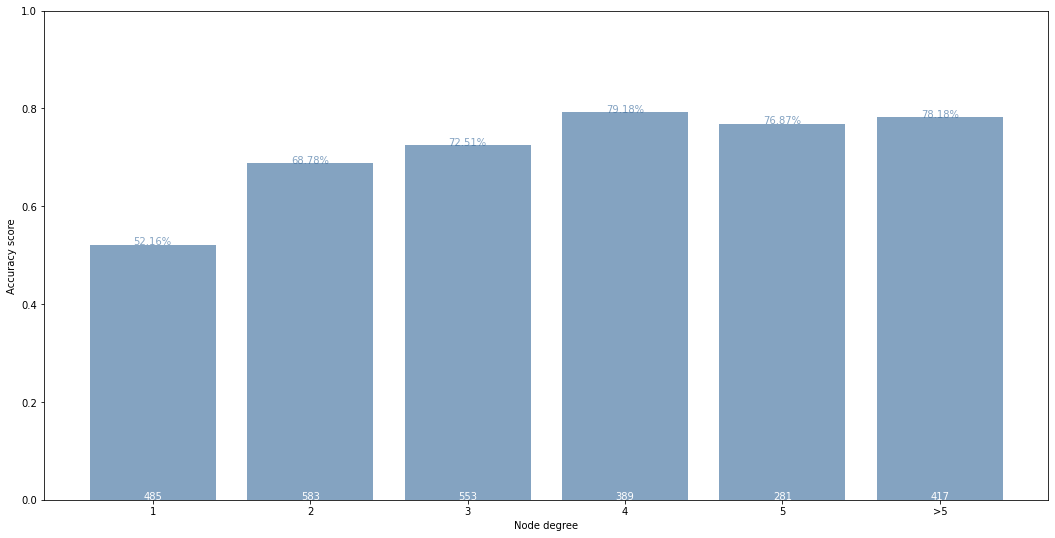

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


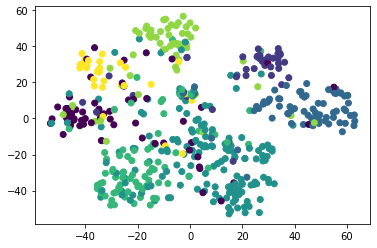

Node task. test set size: 140
heads
2


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch  0 Loss:  1.952310562133789 Train Acc:  0.17857142857142858 Test Acc.:  0.306
Epoch  10 Loss:  1.880212664604187 Train Acc:  0.2642857142857143 Test Acc.:  0.334
Epoch  20 Loss:  1.6269972324371338 Train Acc:  0.37142857142857144 Test Acc.:  0.498
Epoch  30 Loss:  1.1596964597702026 Train Acc:  0.5642857142857143 Test Acc.:  0.63
Epoch  40 Loss:  0.7396371364593506 Train Acc:  0.7214285714285714 Test Acc.:  0.646
Epoch  50 Loss:  0.667316734790802 Train Acc:  0.7785714285714286 Test Acc.:  0.706
Epoch  60 Loss:  0.5398147702217102 Train Acc:  0.8214285714285714 Test Acc.:  0.748
Epoch  70 Loss:  0.4593659043312073 Train Acc:  0.8642857142857143 Test Acc.:  0.73
Epoch  80 Loss:  0.3791067898273468 Train Acc:  0.9 Test Acc.:  0.714
Epoch  90 Loss:  0.38745617866516113 Train Acc:  0.8857142857142857 Test Acc.:  0.776
Epoch  100 Loss:  0.36911889910697937 Train Acc:  0.8714285714285714 Test Acc.:  0.784
Epoch  110 Loss:  0.37006106972694397 Train Acc:  0.8785714285714286 Test Acc.:  

Maximum accuracy: 0.784


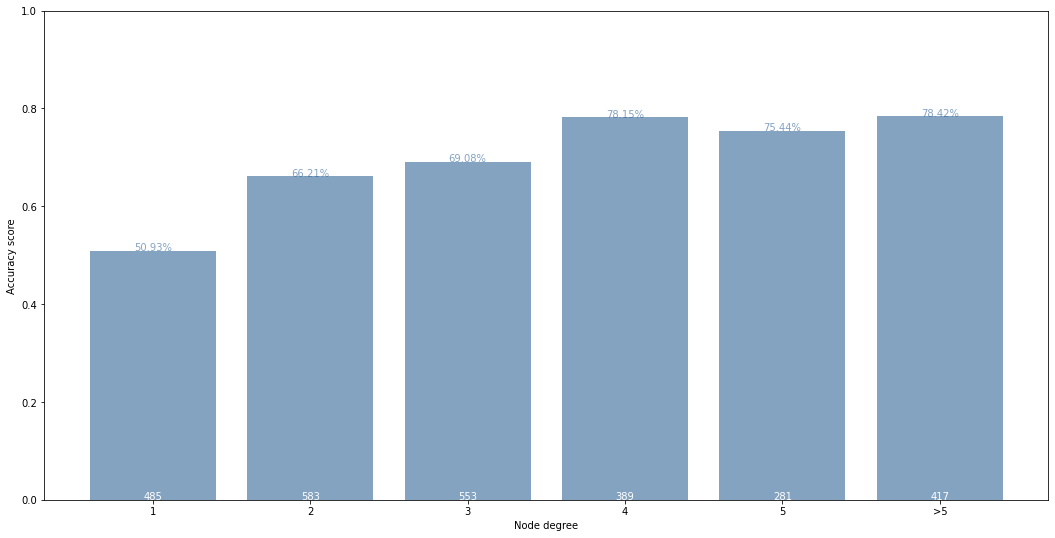

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


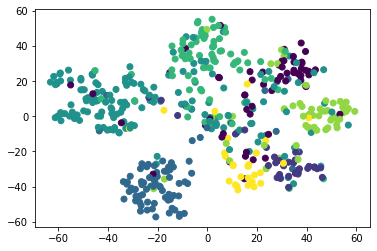

Node task. test set size: 140
heads
2


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch  0 Loss:  1.947790265083313 Train Acc:  0.12142857142857143 Test Acc.:  0.158
Epoch  10 Loss:  1.9260295629501343 Train Acc:  0.21428571428571427 Test Acc.:  0.166
Epoch  20 Loss:  1.7918200492858887 Train Acc:  0.32142857142857145 Test Acc.:  0.152
Epoch  30 Loss:  1.4881317615509033 Train Acc:  0.40714285714285714 Test Acc.:  0.27
Epoch  40 Loss:  1.3085683584213257 Train Acc:  0.42142857142857143 Test Acc.:  0.378
Epoch  50 Loss:  1.139851450920105 Train Acc:  0.5 Test Acc.:  0.53
Epoch  60 Loss:  0.8989519476890564 Train Acc:  0.6571428571428571 Test Acc.:  0.628
Epoch  70 Loss:  0.9086886048316956 Train Acc:  0.6785714285714286 Test Acc.:  0.588
Epoch  80 Loss:  0.7584209442138672 Train Acc:  0.6928571428571428 Test Acc.:  0.628
Epoch  90 Loss:  0.8294466733932495 Train Acc:  0.7285714285714285 Test Acc.:  0.676
Epoch  100 Loss:  0.7338510751724243 Train Acc:  0.7214285714285714 Test Acc.:  0.676
Epoch  110 Loss:  0.8633922934532166 Train Acc:  0.7214285714285714 Test Acc.: 

Maximum accuracy: 0.77


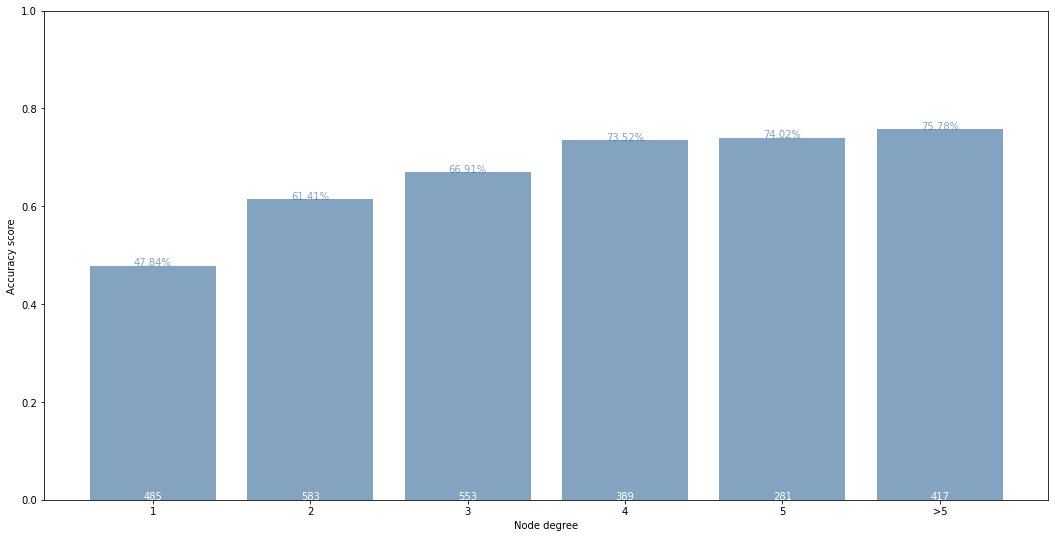

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


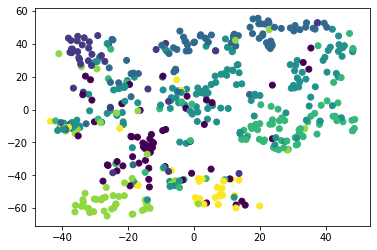

Node task. test set size: 140
heads
2


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch  0 Loss:  1.9579691886901855 Train Acc:  0.1 Test Acc.:  0.268
Epoch  10 Loss:  1.9414551258087158 Train Acc:  0.15714285714285714 Test Acc.:  0.266
Epoch  20 Loss:  1.9327216148376465 Train Acc:  0.18571428571428572 Test Acc.:  0.15
Epoch  30 Loss:  1.7915352582931519 Train Acc:  0.21428571428571427 Test Acc.:  0.11
Epoch  40 Loss:  1.6371530294418335 Train Acc:  0.32142857142857145 Test Acc.:  0.228
Epoch  50 Loss:  1.6120277643203735 Train Acc:  0.25 Test Acc.:  0.21
Epoch  60 Loss:  1.4357622861862183 Train Acc:  0.32857142857142857 Test Acc.:  0.278
Epoch  70 Loss:  1.4544334411621094 Train Acc:  0.3357142857142857 Test Acc.:  0.336
Epoch  80 Loss:  1.4609744548797607 Train Acc:  0.3 Test Acc.:  0.296
Epoch  90 Loss:  1.4093469381332397 Train Acc:  0.35714285714285715 Test Acc.:  0.3
Epoch  100 Loss:  1.3811931610107422 Train Acc:  0.35714285714285715 Test Acc.:  0.284
Epoch  110 Loss:  1.406570553779602 Train Acc:  0.38571428571428573 Test Acc.:  0.212
Epoch  120 Loss:  1.3

Maximum accuracy: 0.438


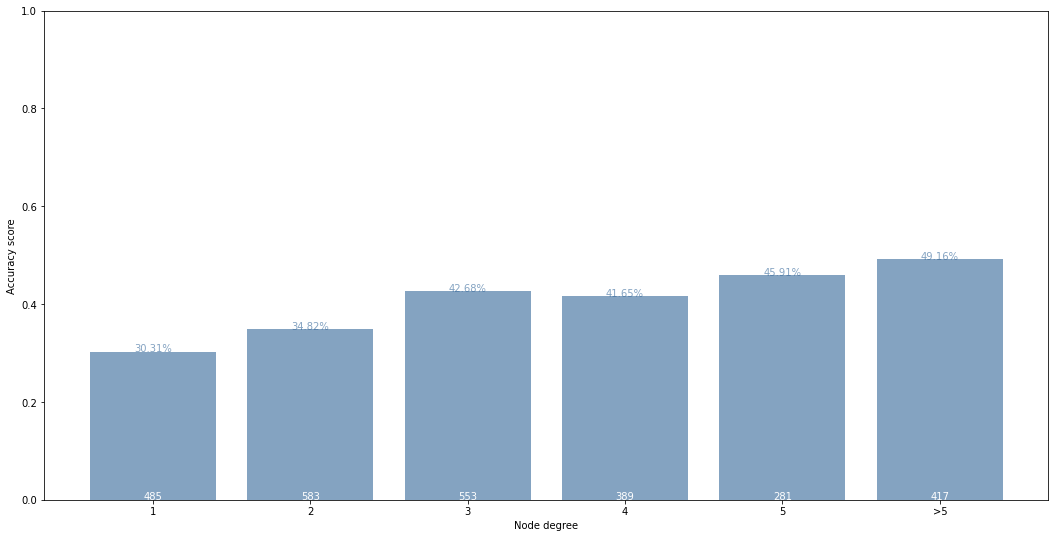

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


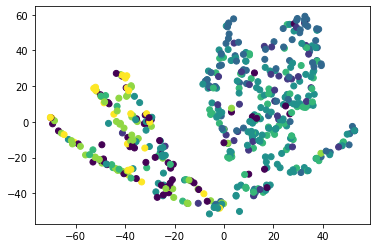

Node task. test set size: 140
heads
2


/usr/local/lib/python3.8/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch  0 Loss:  1.9473721981048584 Train Acc:  0.12142857142857143 Test Acc.:  0.162
Epoch  10 Loss:  1.9321905374526978 Train Acc:  0.17857142857142858 Test Acc.:  0.278
Epoch  20 Loss:  1.9560546875 Train Acc:  0.12142857142857143 Test Acc.:  0.09
Epoch  30 Loss:  1.8857890367507935 Train Acc:  0.2857142857142857 Test Acc.:  0.194
Epoch  40 Loss:  1.6802234649658203 Train Acc:  0.2714285714285714 Test Acc.:  0.222
Epoch  50 Loss:  1.6160242557525635 Train Acc:  0.34285714285714286 Test Acc.:  0.238
Epoch  60 Loss:  1.5330909490585327 Train Acc:  0.35714285714285715 Test Acc.:  0.224
Epoch  70 Loss:  1.3894712924957275 Train Acc:  0.37857142857142856 Test Acc.:  0.274
Epoch  80 Loss:  1.3658369779586792 Train Acc:  0.37857142857142856 Test Acc.:  0.29
Epoch  90 Loss:  1.5036616325378418 Train Acc:  0.3142857142857143 Test Acc.:  0.294
Epoch  100 Loss:  1.4088691473007202 Train Acc:  0.38571428571428573 Test Acc.:  0.362
Epoch  110 Loss:  1.3348239660263062 Train Acc:  0.31428571428571

Maximum accuracy: 0.372


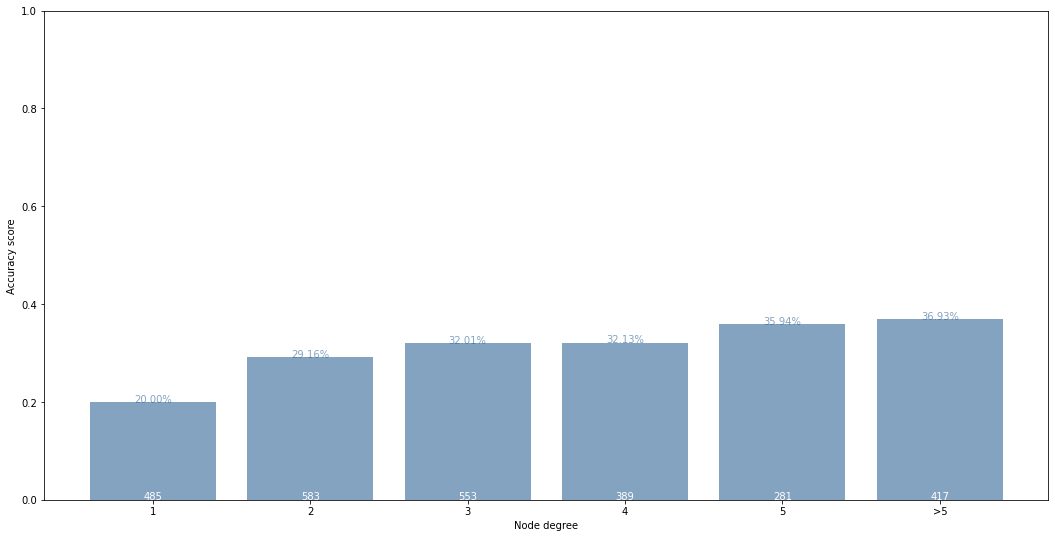

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


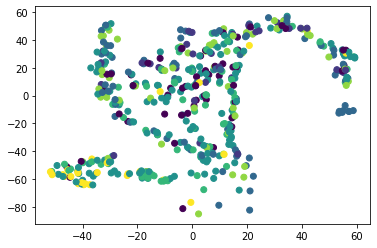

In [ ]:
def main():
  args={'model_type': 'GATConv', 'dataset': 'Cora', 'num_layers': 2, 'heads': 2, 
         'batch_size': 64, 'hidden_dim': 64, 'dropout': 0.6, 'epochs': 200, 
         'opt': 'adam', 'opt_scheduler': 'none', 'opt_restart': 0, 
         'weight_decay': 5e-3, 'lr': 0.005}
  for num_layers in [1,2,3,4,5,6]:
      args["num_layers"]=num_layers
      if args["dataset"] == 'Cora':
        dataset=Planetoid(root=".", name="Cora")
      else: 
        dataset=Planetoid(root=".", name="Citeseer")
      test_accs, losses, model_conv = train(dataset, args) 
      print("Maximum accuracy: {0}".format(max(test_accs)))
      #print("Minimum loss: {0}".format(min(losses)))
      #plt.title(dataset.name+" "+  args["model_type"]+" "+str(args["batch_size"])+" "+str(args["hidden_dim"]))
      #plt.plot(losses, label="training loss" + " - " + args["model_type"])
      #plt.plot(test_accs, label="test accuracy" + " - " + args["model_type"])
      generateGraph(model_conv)
      dimension_reduction(model_conv)
      #plt.legend()
      #plt.show()
    
if __name__ == '__main__':
    main()

# explore different components
layer = 1 --> 没有postmp
